In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
original_df = pd.read_csv("../0. Data/classification_data.csv")
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])
original_df.columns.to_list()

['Sample',
 'Position',
 'Country',
 'City',
 'Plant',
 'Date',
 'Volume of aeration tanks (m3)',
 'Actual Inf rate (m3/d)',
 '℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Humidity.Max.SamplingDate',
 '℃ Humidity.Min.SamplingDate',
 '℃ Wind.Max.SamplingDate',
 '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate',
 '℃ Pressure.Min.SamplingDate',
 '℃ Precipitation.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Humidity.Max.WeekMean',
 '℃ Humidity.Min.WeekMean',
 '℃ Wind.Max.WeekMean',
 '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean',
 '℃ Pressure.Min.WeekMean',
 '℃ Precipitation.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 

In [3]:
as_list = [
    'NewcastleAS', 'VarbergAS', 'SFAS',
    'Beijing3AS', 'Beijing2AS', 'GuangzhouAS',
    'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
    'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4',
    'LisbonAS', 'ChicagoAS',
    'NormanASP1', 'NormanASP2', 'NormanASP3'
]

filtered_df = original_df[original_df["Position"].isin(as_list)]
len(as_list)
print(original_df["Position"].unique(), filtered_df["Position"].unique())

['NewcastleAS' 'VarbergAS' 'VarbergINF' 'SFAS' 'SFINF' 'Bejing3INF'
 'Beijing3AS' 'Beijing2AS' 'Beijing2INF' 'GuangzhouINF' 'GuangzhouAS'
 'KnoxvilleINF' 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3'
 'DurbanASP1' 'DurbanASP2' 'DurbanASP3' 'DurbanASP4' 'LisbonINF'
 'LisbonAS' 'ChicagoAS' 'NormanINF' 'NormanASP1' 'NormanASP2' 'NormanASP3'
 'NormanEFF'] ['NewcastleAS' 'VarbergAS' 'SFAS' 'Beijing3AS' 'Beijing2AS' 'GuangzhouAS'
 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3' 'DurbanASP1' 'DurbanASP2'
 'DurbanASP3' 'DurbanASP4' 'LisbonAS' 'ChicagoAS' 'NormanASP1'
 'NormanASP2' 'NormanASP3']


In [4]:
X_svd_df = pd.read_csv("../0. Data/ESV_SVD_25D.csv", index_col=0)
X_svd_df

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25
UK01A,119.512586,30.206870,257.892781,244.542209,1476.170952,-886.607324,877.460751,-748.717582,-459.228337,-222.319253,...,359.310911,-89.069847,35.938781,-80.955725,74.555696,204.643887,-44.432424,-75.566567,-28.152542,-139.776911
UK02A,184.855875,44.575649,394.888152,340.562363,2222.852732,-1271.239892,1316.628486,-1090.680760,-736.107534,-323.143894,...,590.358520,-68.025554,-130.805420,-132.906720,124.226026,291.279505,-43.424642,-21.048832,-121.881068,-222.789861
UK03A,176.093600,47.116199,391.320514,351.139450,2224.944927,-1291.757728,1319.204476,-1115.554144,-725.117653,-331.408948,...,573.401686,-61.099369,-127.653732,-125.362428,118.647594,264.290790,-21.878628,-38.734378,-73.757111,-183.435814
UK04A,188.055920,45.143048,405.899105,335.812563,2275.728090,-1367.835375,1378.402861,-1152.497381,-787.089174,-359.224185,...,598.514885,-104.100813,-251.199593,-164.765123,188.262919,316.618341,-25.531131,10.909645,-205.971329,-358.286225
UK05A,183.131358,45.603622,414.252648,326.158036,2297.905647,-1415.437251,1424.057599,-1168.939447,-812.225139,-382.059660,...,649.802823,-171.539529,-265.680254,-160.743738,161.550729,365.633693,-83.970978,-1.510278,-207.412524,-486.803164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GZ101,494.238896,-38.824252,31.679222,121.701359,359.688041,-1.272138,50.041731,354.381228,781.470751,212.451309,...,-112.166328,58.385814,102.919704,72.808057,-94.706035,-13.287829,140.859177,199.582808,72.440998,-135.446180
GZ102,305.125160,42.983298,41.087944,183.634098,399.361700,15.441426,74.218017,416.102790,817.795276,118.619032,...,-79.298511,51.476070,23.173439,75.400952,-81.106475,-41.925868,50.742185,150.559234,90.515057,-98.718260
GZ103,189.396822,91.082964,48.823397,181.868279,492.019812,38.842927,82.219243,506.441452,1299.410536,137.176615,...,-100.969706,23.984718,-30.219658,158.638139,-247.486326,36.096102,117.122560,71.440781,237.915310,-110.151610
GZ104,156.687353,127.642448,46.379917,193.862037,501.665470,40.127084,70.643125,529.404743,1460.791904,158.691635,...,-103.062245,-62.725783,-0.736163,183.274059,-249.849197,1.157861,190.774279,53.071887,324.480931,-144.010866


In [5]:

filtered_df_indexed = filtered_df.set_index("Sample")

# X_svd_df와 병합
merged_df = filtered_df_indexed.join(X_svd_df, how="inner")

# 결과 확인
print(merged_df.shape)
merged_df

(813, 115)


,Position,Country,City,Plant,Date,Volume of aeration tanks (m3),Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,...,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25
UK01A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-01-28,3600.0,17254.0,6.67,3.33,0.56,...,359.310911,-89.069847,35.938781,-80.955725,74.555696,204.643887,-44.432424,-75.566567,-28.152542,-139.776911
UK02A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-04,3600.0,7007.0,5.56,3.33,0.56,...,590.358520,-68.025554,-130.805420,-132.906720,124.226026,291.279505,-43.424642,-21.048832,-121.881068,-222.789861
UK03A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-11,3600.0,7197.0,5.56,4.44,2.78,...,573.401686,-61.099369,-127.653732,-125.362428,118.647594,264.290790,-21.878628,-38.734378,-73.757111,-183.435814
UK04A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-18,3600.0,6126.0,11.67,10.00,8.89,...,598.514885,-104.100813,-251.199593,-164.765123,188.262919,316.618341,-25.531131,10.909645,-205.971329,-358.286225
UK05A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-25,3600.0,6898.0,10.56,7.78,5.56,...,649.802823,-171.539529,-265.680254,-160.743738,161.550729,365.633693,-83.970978,-1.510278,-207.412524,-486.803164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,NormanASP3,United States,Norman,USNO2,2015-12-23,9751.2,31922.0,20.56,9.44,-1.67,...,79.002384,-127.434802,376.146945,19.078335,-74.248669,103.338832,-214.610152,-190.040699,242.680544,205.719815
N49C,NormanASP3,United States,Norman,USNO2,2015-12-30,9751.2,45538.0,0.56,-2.22,-5.56,...,16.530354,-34.585756,301.029151,29.531855,43.658539,-140.688473,100.361306,230.568493,-241.501097,-234.927432
N50C,NormanASP3,United States,Norman,USNO2,2016-01-06,9751.2,39274.0,11.67,8.33,4.44,...,-78.089860,-222.846491,431.170700,38.761832,-266.749614,451.700897,-581.428367,-649.538278,782.778535,448.260753
N51C,NormanASP3,United States,Norman,USNO2,2016-01-13,9751.2,34284.0,14.44,5.56,-3.33,...,-178.605008,-386.187801,824.720211,23.364556,-232.236579,570.914432,-596.004992,-930.312088,916.910955,438.088537


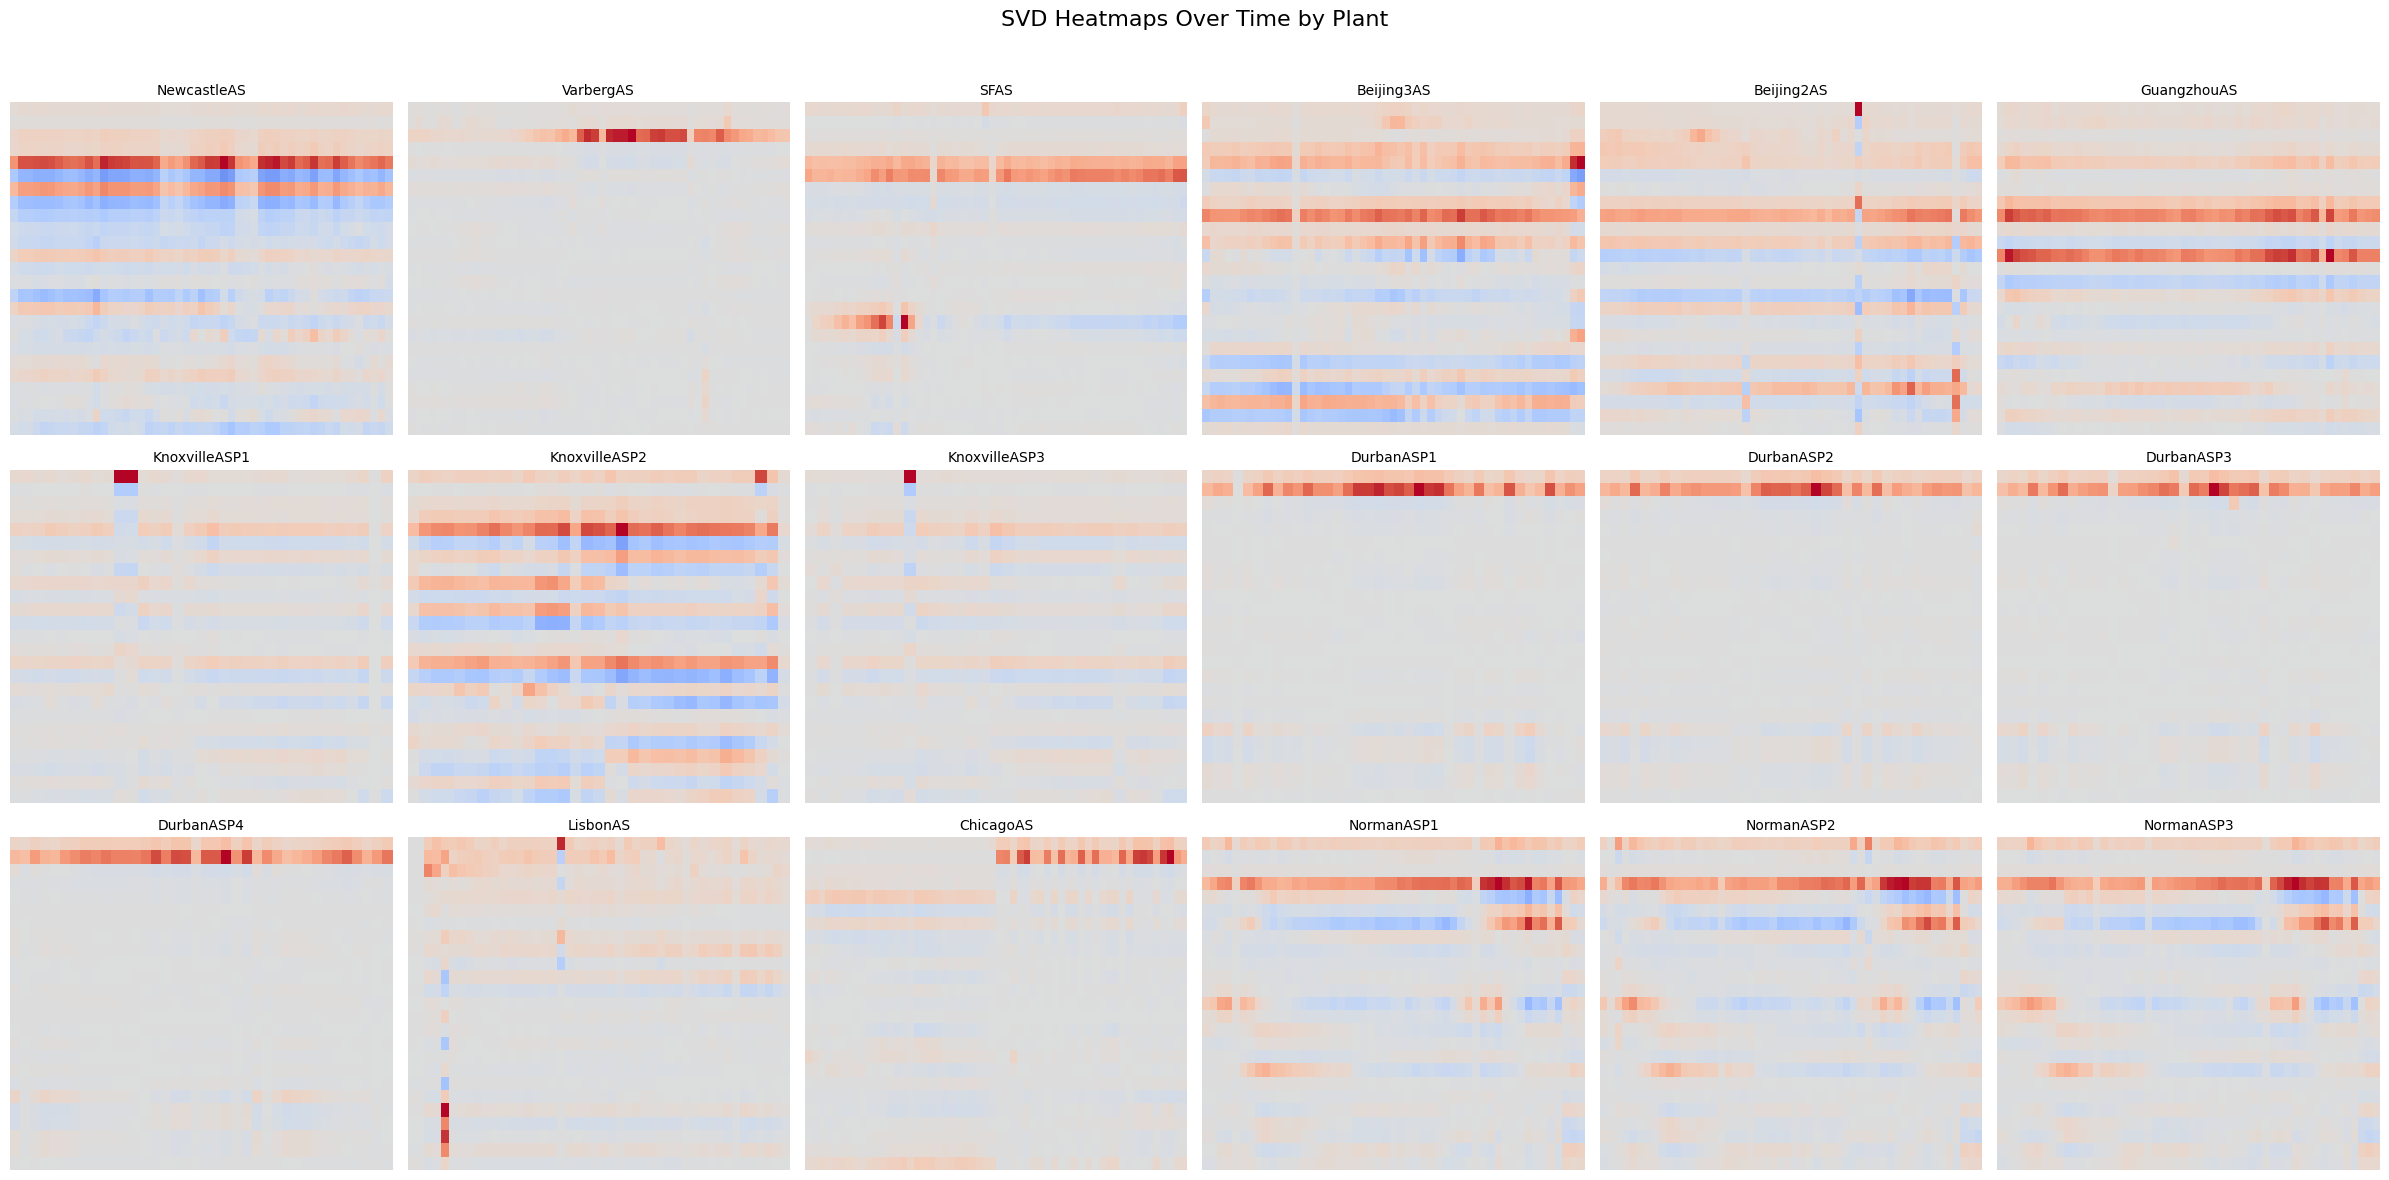

In [7]:

# SVD 컬럼
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# Date를 datetime으로 변환
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Plant 리스트 (상위 18개만 사용)
plant_list = merged_df["Position"].unique()[:18]

# 서브플롯 설정
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

for i, plant_name in enumerate(plant_list):
    ax = axes[i]

    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        ax.set_visible(False)
        continue

    group_df = group_df.set_index("Date")
    svd_data = group_df[svd_cols].T  # SVDs on y-axis

    sns.heatmap(svd_data, cmap="coolwarm", center=0, ax=ax,
                cbar=False, xticklabels=False, yticklabels=False)

    ax.set_title(plant_name, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

# 전체 레이아웃 조정
plt.suptitle("SVD Heatmaps Over Time by Plant", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


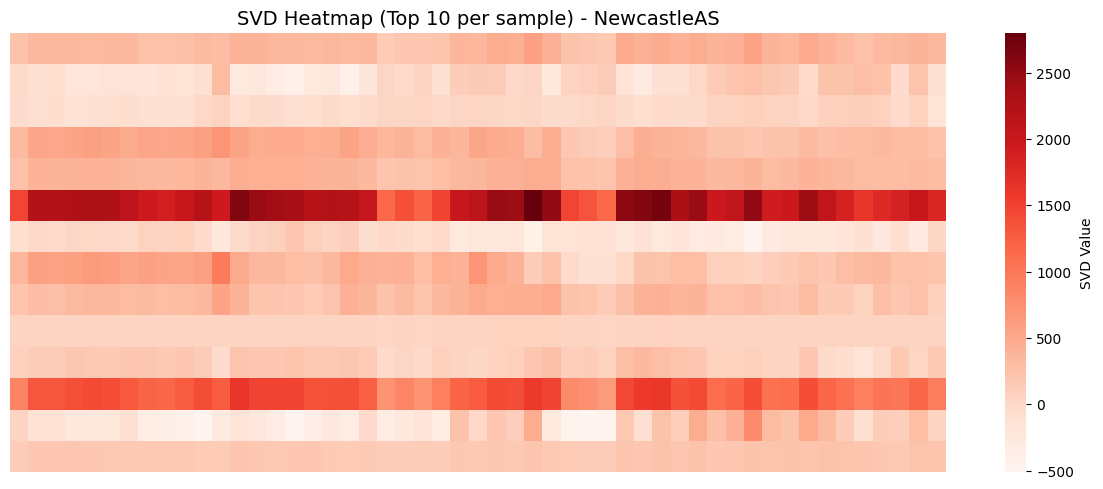

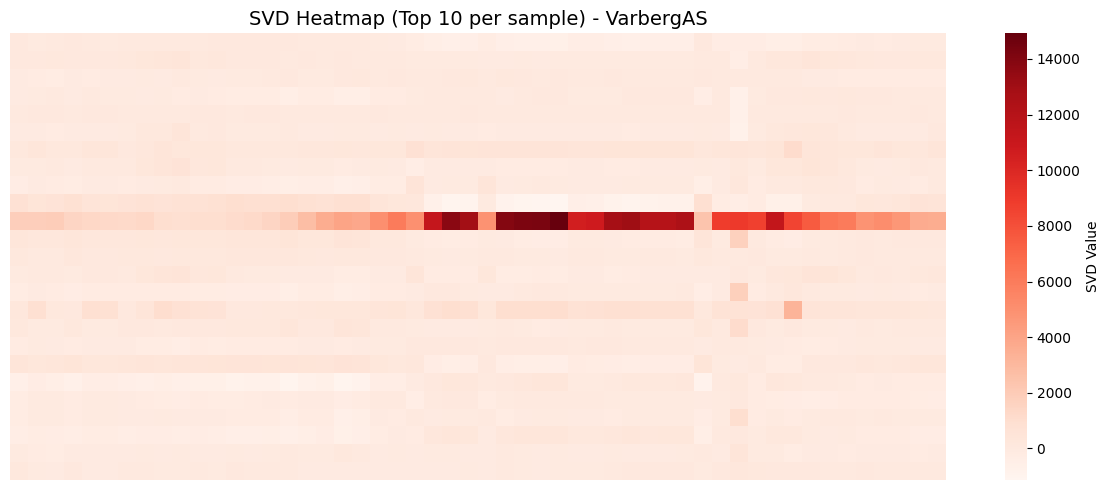

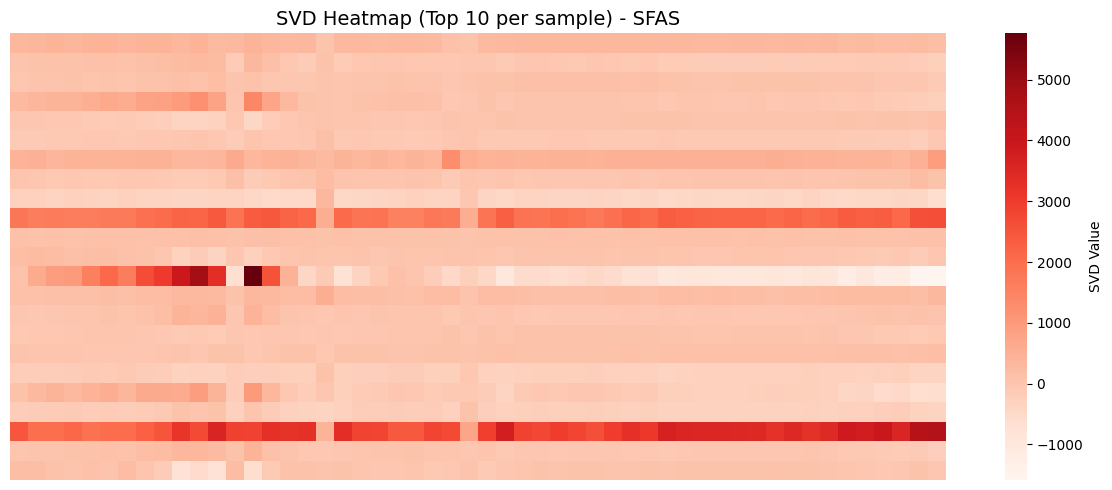

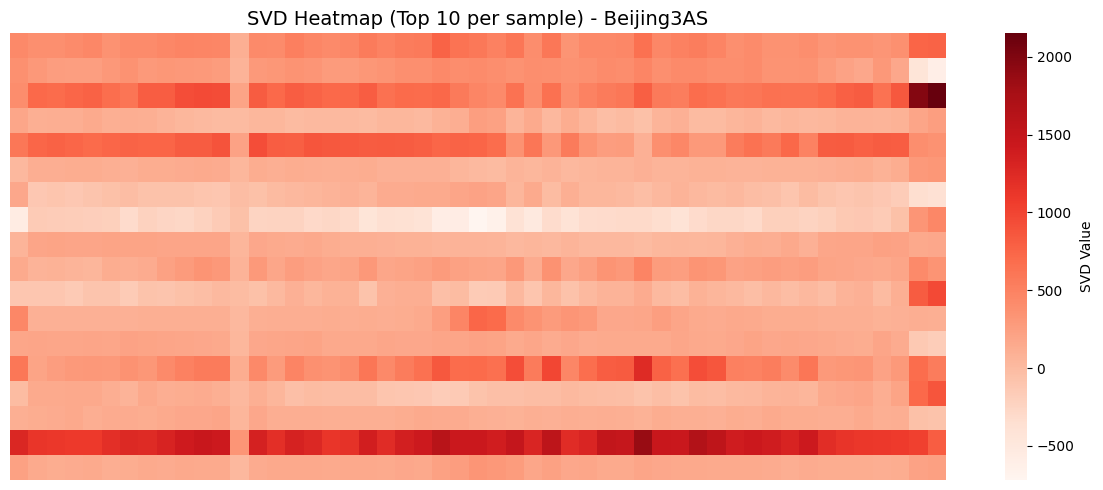

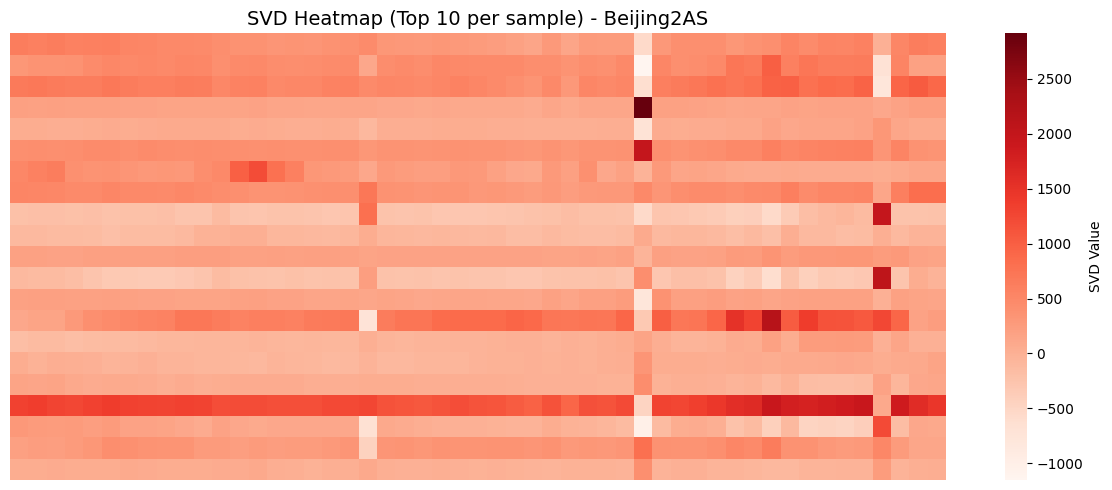

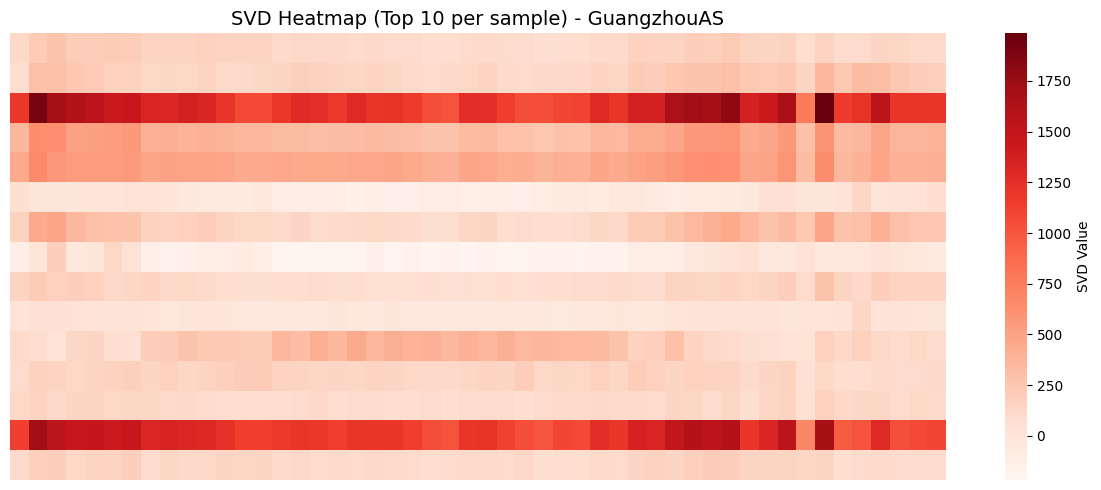

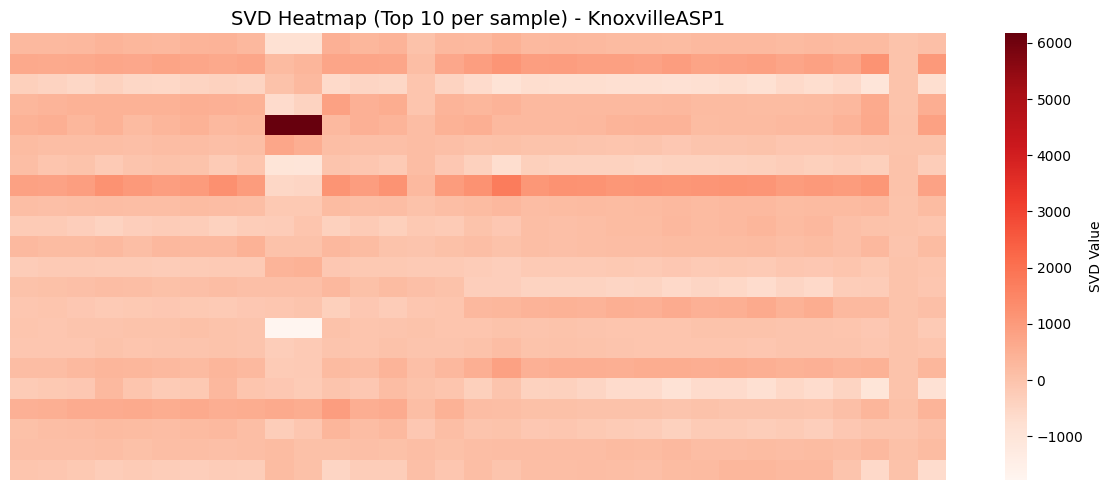

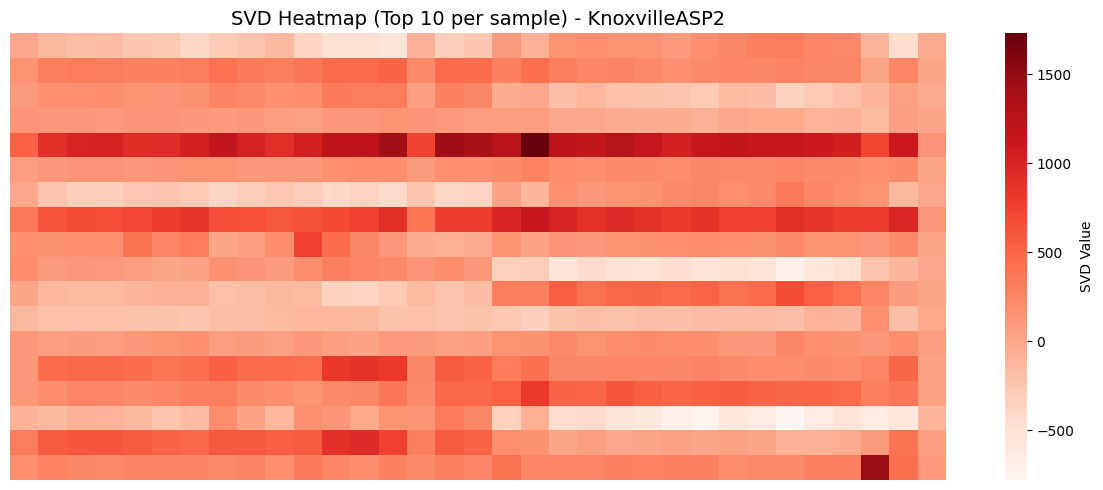

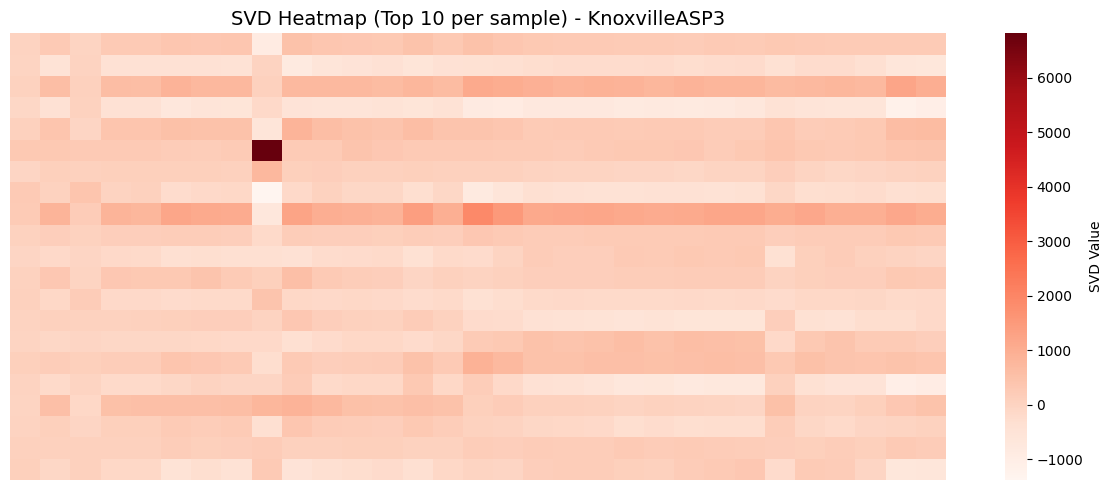

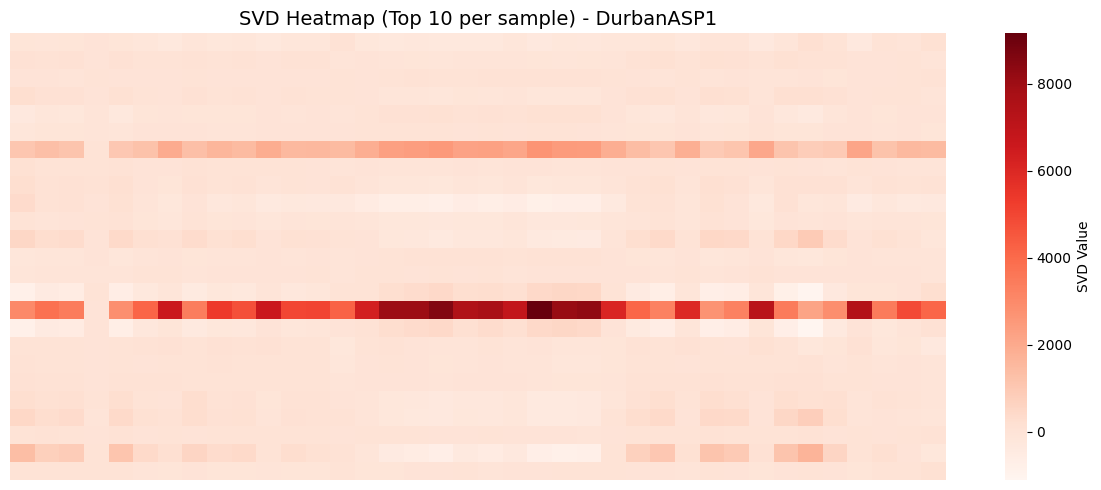

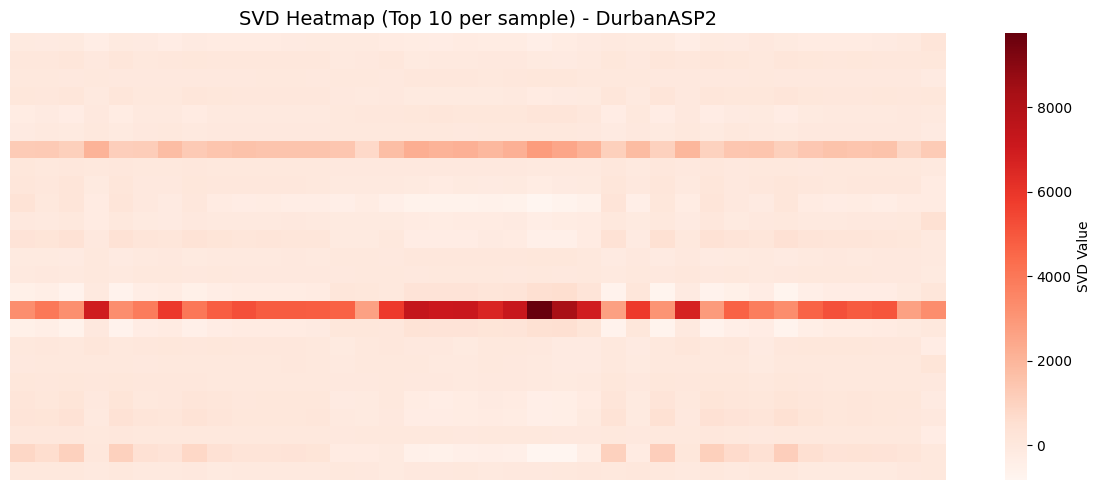

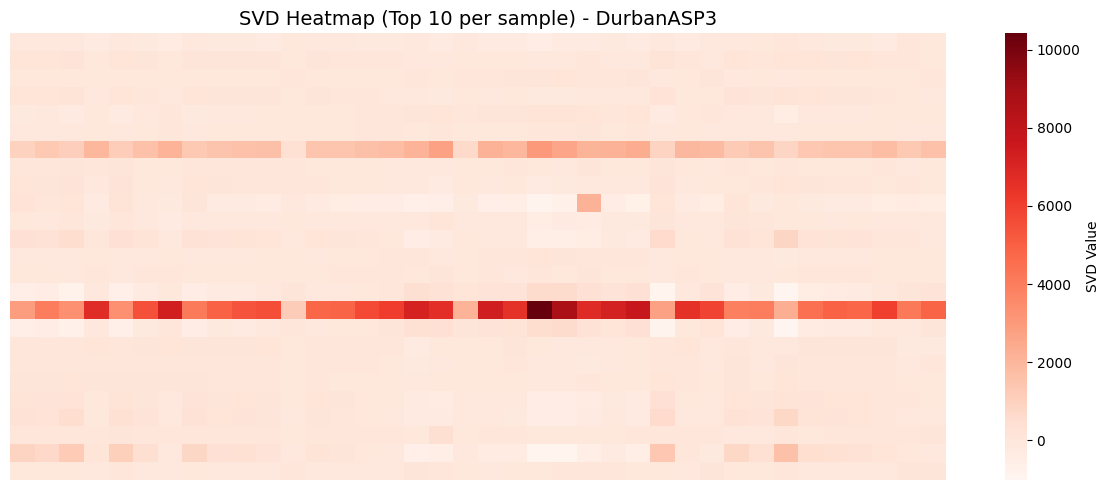

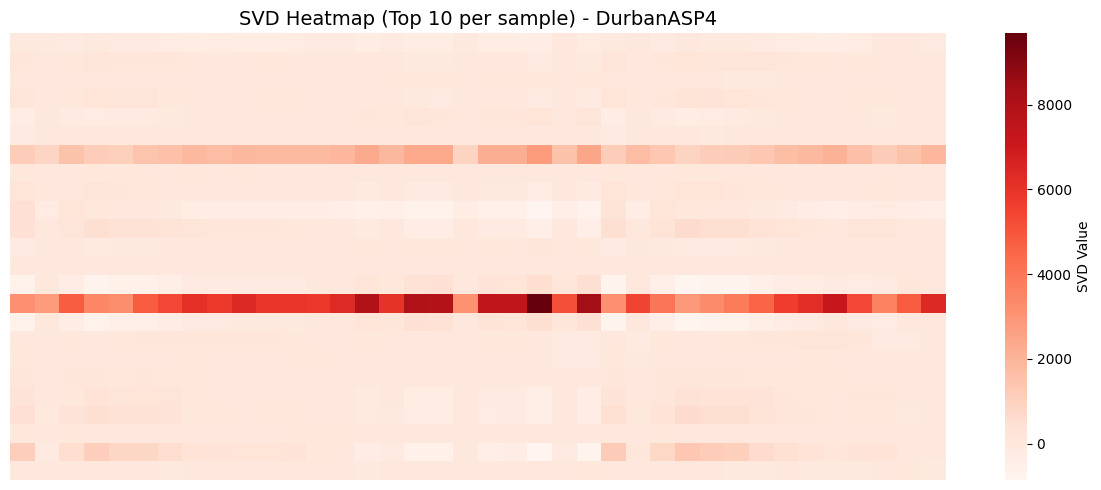

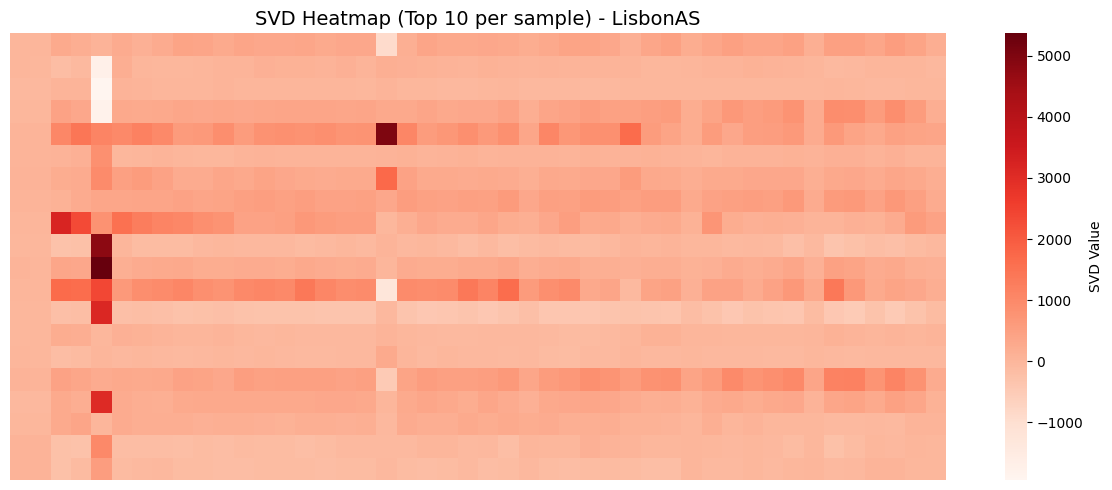

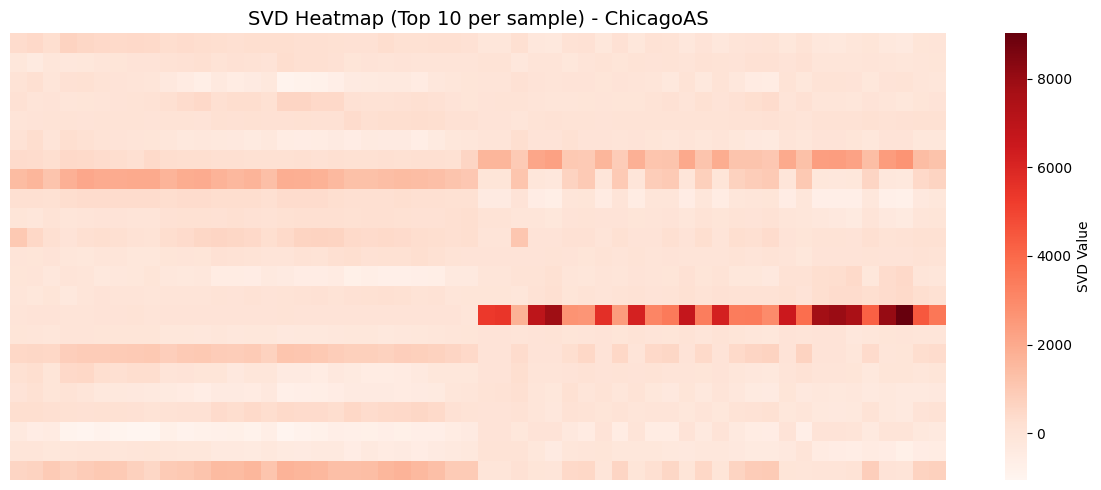

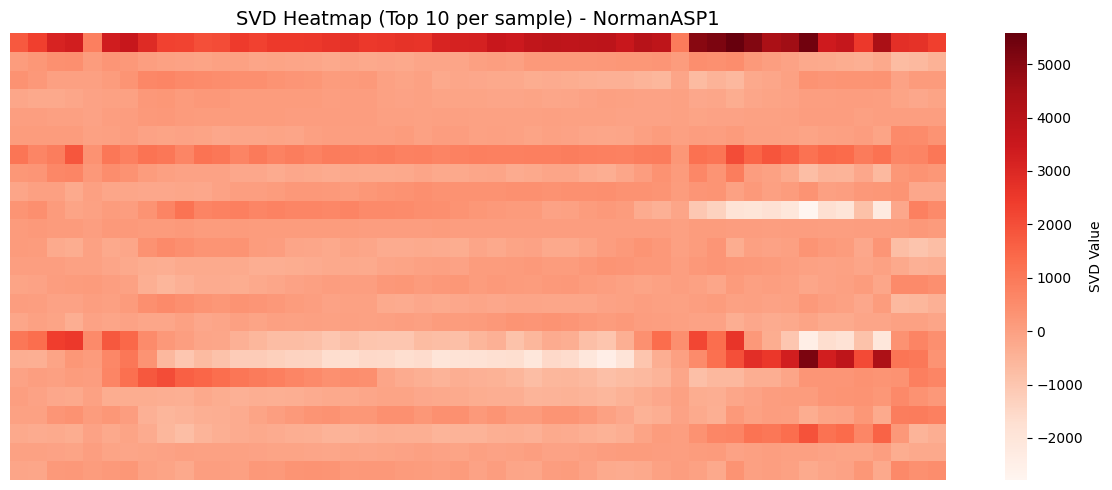

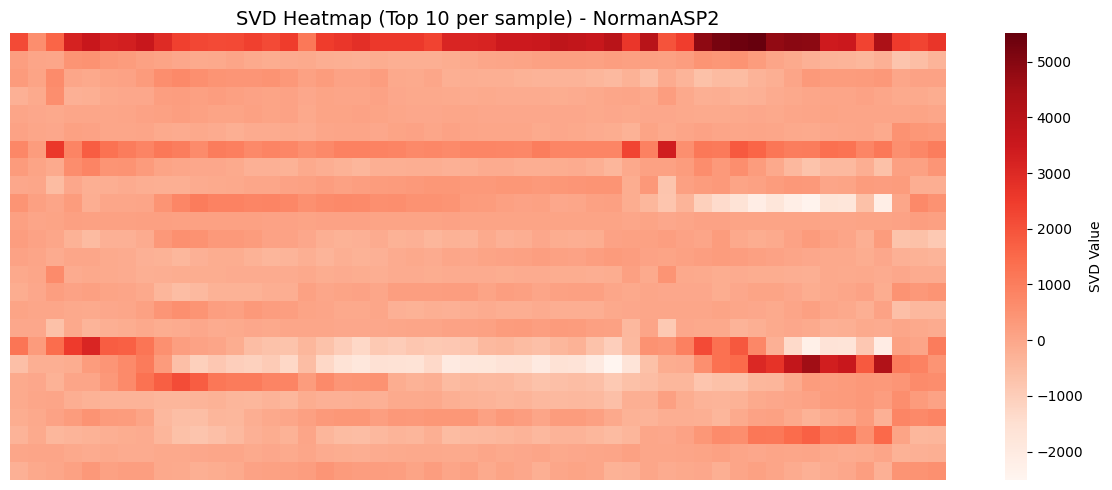

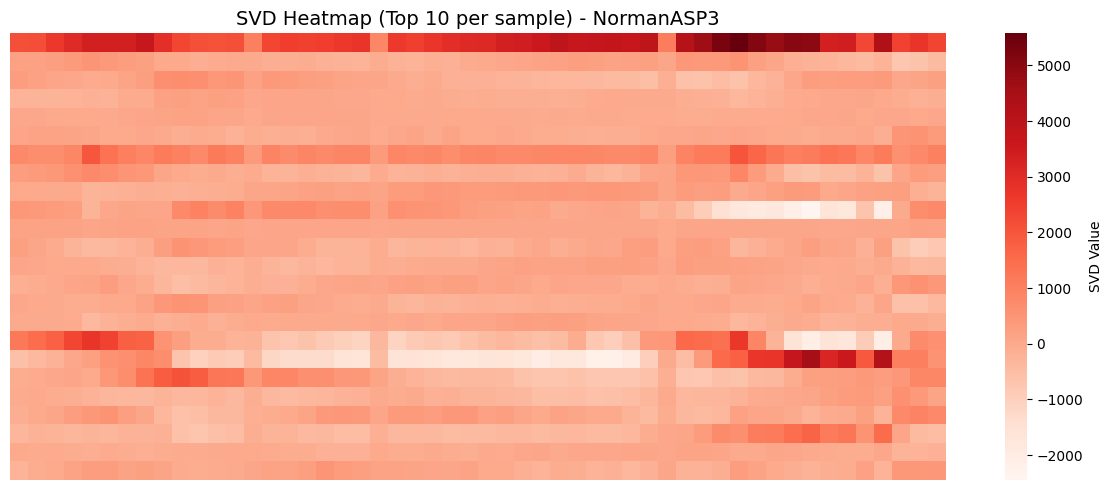

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SVD 컬럼 리스트
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# 날짜 처리
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# 플랜트 리스트
plant_list = merged_df["Position"].unique()[:18]

for plant_name in plant_list:
    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        continue

    group_df = group_df.set_index("Date")
    svd_only = group_df[svd_cols]

    # 각 row(날짜)에 대해 상위 10개 SVD 컬럼만 남기기
    top10_svd_cols = svd_only.apply(lambda row: row.nlargest(10).index, axis=1)
    top_svd_set = set(top10_svd_cols.explode())  # 유니크한 컬럼만 추출

    # 필터링된 SVD 데이터 (상위 10개 컬럼만 유지)
    filtered_svd = svd_only[list(top_svd_set)].T

    # 히트맵 그리기
    plt.figure(figsize=(12, 5))
    sns.heatmap(
        filtered_svd,
        cmap="Reds",
        cbar_kws={'label': 'SVD Value'},
        xticklabels=False,
        yticklabels=False
    )

    plt.title(f"SVD Heatmap (Top 10 per sample) - {plant_name}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# SVD 컬럼만
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# 전체 결과 저장용
baseline_mse = {}
baseline_r2 = {}

# 각 플랜트 별로
for plant_name in merged_df["Position"].unique():
    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        continue

    y_true = group_df[svd_cols].iloc[1:].values     # 실제값 (t)
    y_pred = group_df[svd_cols].iloc[:-1].values    # 직전값으로 예측 (t-1)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    baseline_mse[plant_name] = mse
    baseline_r2[plant_name] = r2

# 예시 출력
for plant in list(baseline_mse.keys()):
    print(f"{plant} → MSE: {baseline_mse[plant]:.4f}, R²: {baseline_r2[plant]:.4f}")


NewcastleAS → MSE: 25705.1492, R²: 0.2546
VarbergAS → MSE: 355932.0185, R²: 0.0548
SFAS → MSE: 110717.1427, R²: 0.0049
Beijing3AS → MSE: 19236.4634, R²: 0.3128
Beijing2AS → MSE: 91547.1204, R²: -0.4366
GuangzhouAS → MSE: 8862.2345, R²: 0.2115
KnoxvilleASP1 → MSE: 151830.9410, R²: -0.0910
KnoxvilleASP2 → MSE: 25408.2844, R²: 0.1716
KnoxvilleASP3 → MSE: 188144.0921, R²: -0.3655
DurbanASP1 → MSE: 217784.0431, R²: -0.0351
DurbanASP2 → MSE: 199896.6102, R²: -0.2175
DurbanASP3 → MSE: 304356.1957, R²: -0.4514
DurbanASP4 → MSE: 203237.8499, R²: -0.1313
LisbonAS → MSE: 242118.1118, R²: -0.6285
ChicagoAS → MSE: 245873.1577, R²: 0.3902
NormanASP1 → MSE: 137378.9501, R²: 0.4261
NormanASP2 → MSE: 136319.8758, R²: 0.2970
NormanASP3 → MSE: 112459.5829, R²: 0.5259


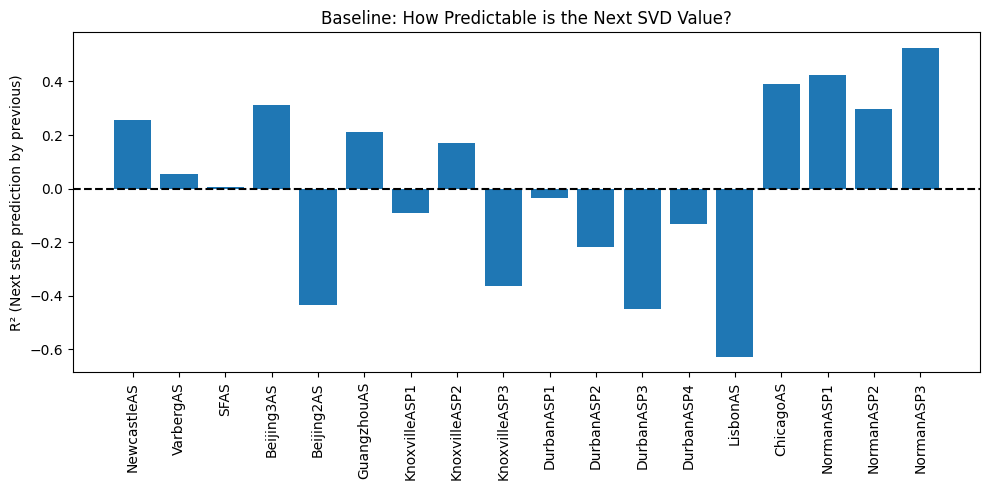

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(baseline_r2.keys(), baseline_r2.values())
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("R² (Next step prediction by previous)")
plt.title("Baseline: How Predictable is the Next SVD Value?")
plt.tight_layout()
plt.show()


In [37]:
from statsmodels.tsa.stattools import adfuller

# 예: 특정 플랜트의 SVD_1 시계열
plant = "DurbanASP2"
svd_series = merged_df[merged_df['Position'] == plant].sort_values("Date")["SVD_6"].dropna()

# ADF Test 수행
result = adfuller(svd_series)

# 출력
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -0.6059367068453284
p-value: 0.8696349237248795
Critical Value (1%): -3.6790595944893187
Critical Value (5%): -2.9678817237279103
Critical Value (10%): -2.6231583472057074


In [38]:
# 1차 차분
diff_series = svd_series.diff().dropna()

# ADF Test on 차분 데이터
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)

print(f"ADF Statistic (1차 차분): {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic (1차 차분): -0.0494353982921964
p-value: 0.9542478162206319


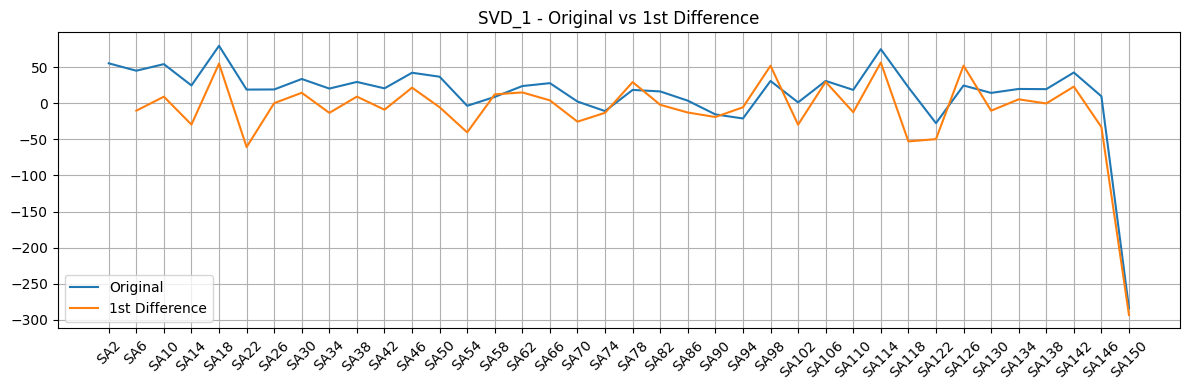

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(svd_series, label='Original')
plt.plot(diff_series, label='1st Difference')

plt.legend()
plt.title("SVD_1 - Original vs 1st Difference")
plt.grid(True)

# ✅ x축 라벨 회전
plt.xticks(rotation=45)  # 또는 rotation=90 으로 완전 수직

plt.tight_layout()
plt.show()


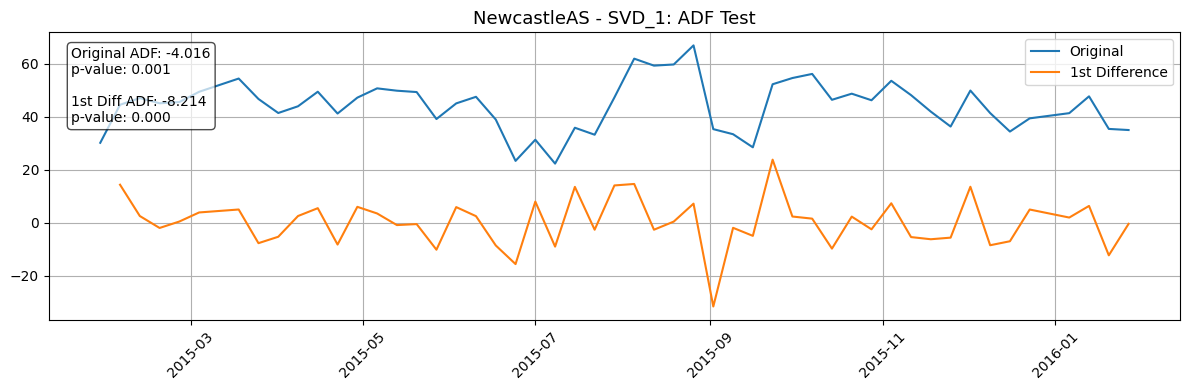

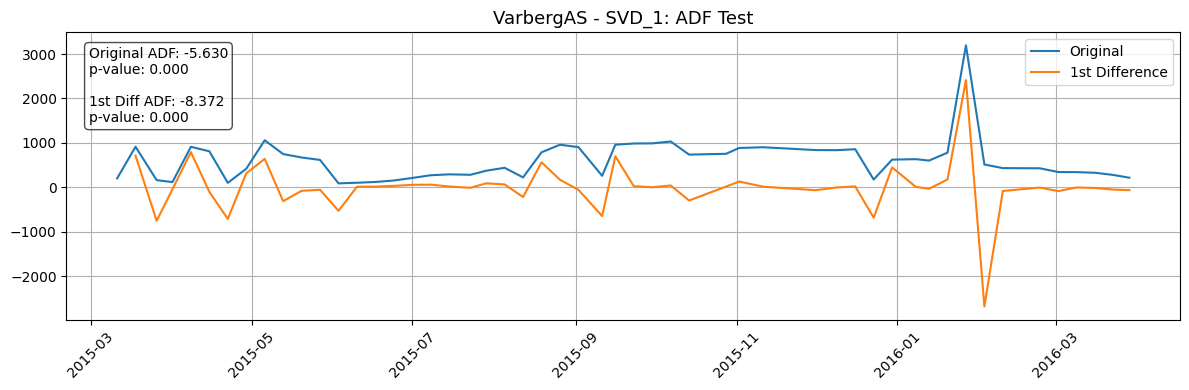

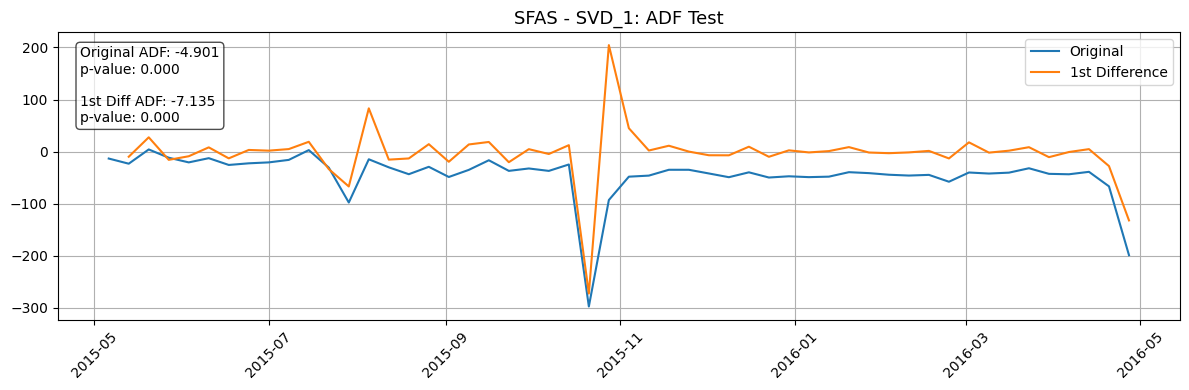

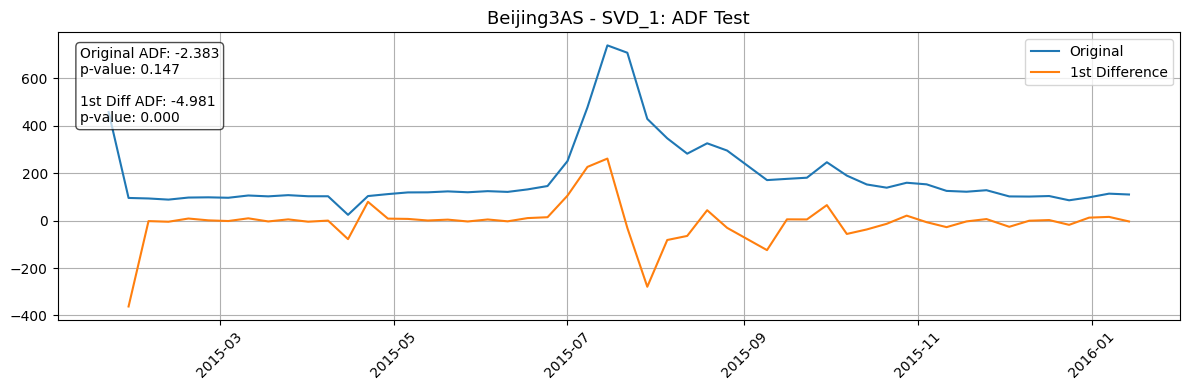

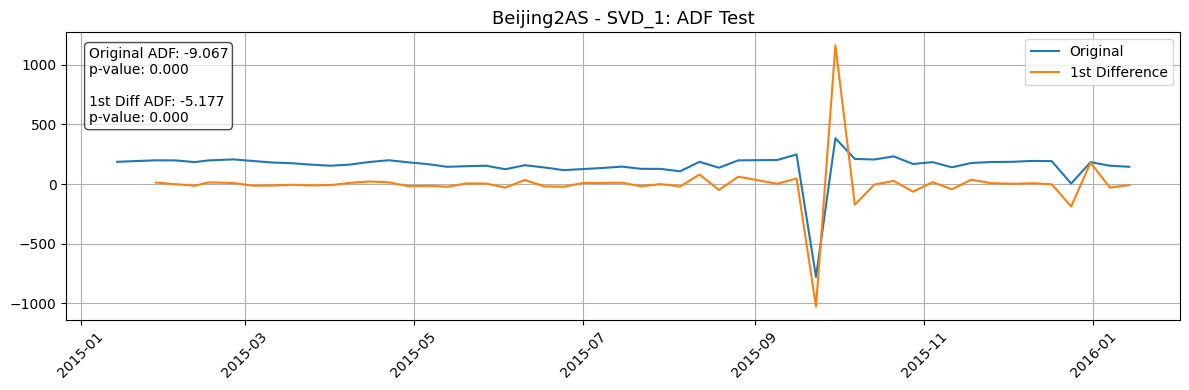

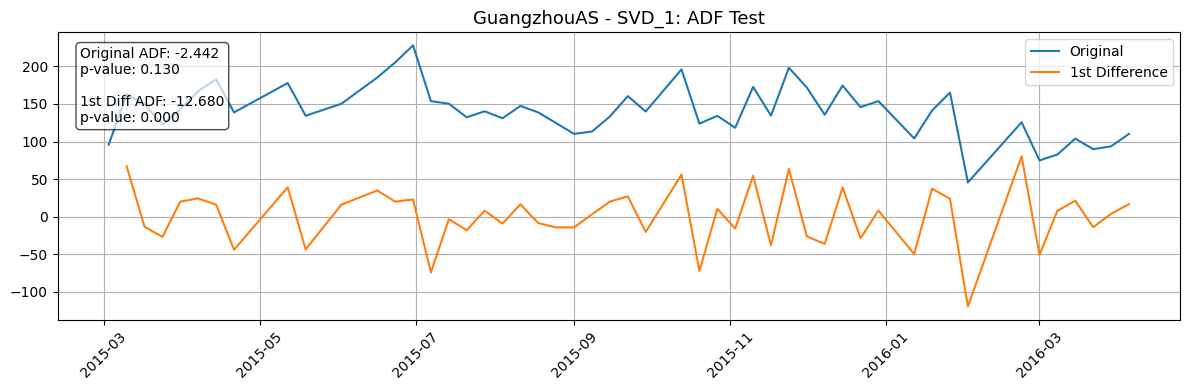

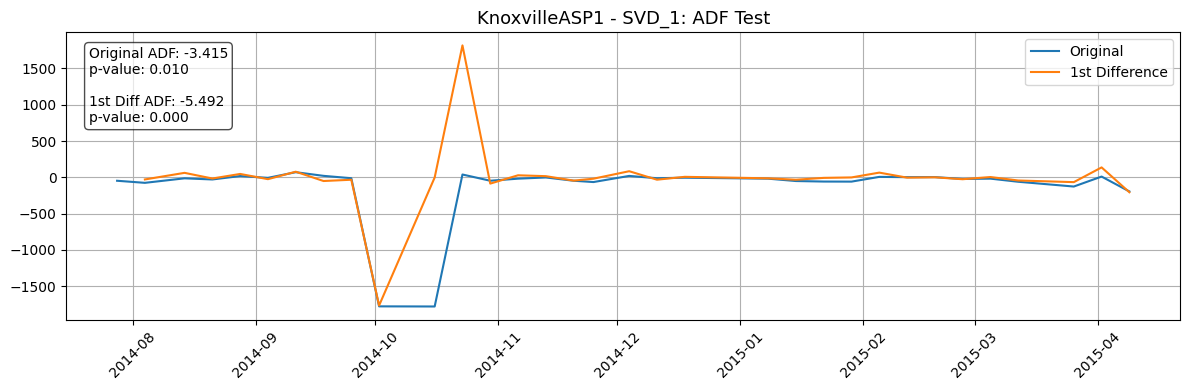

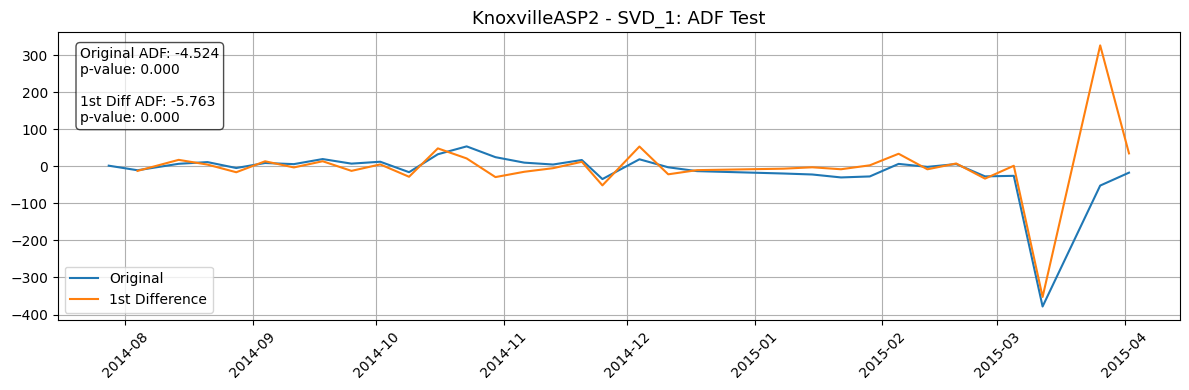

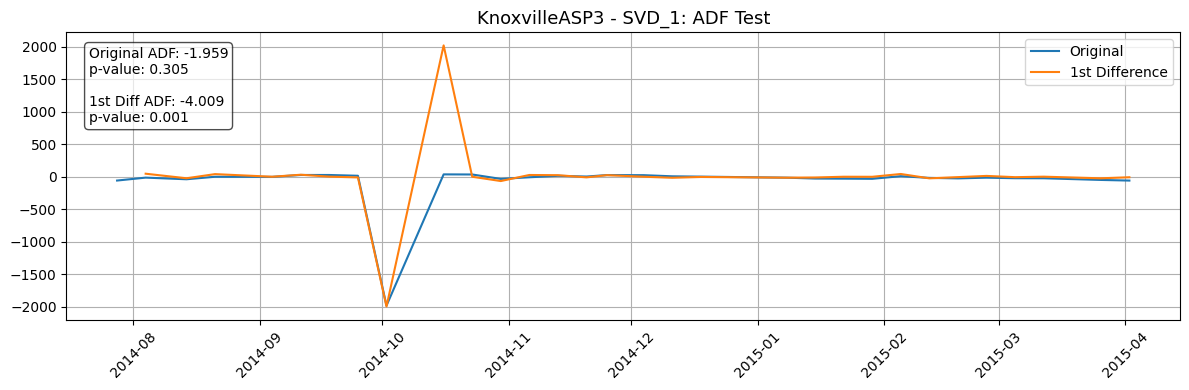

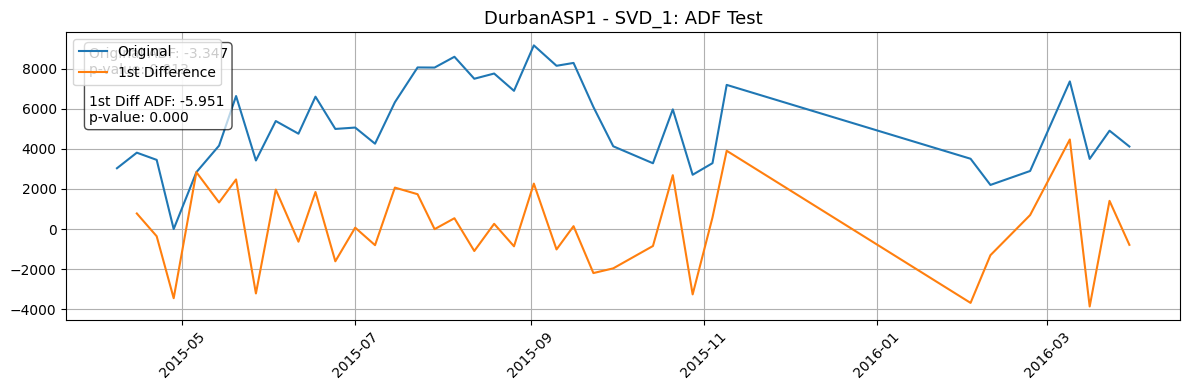

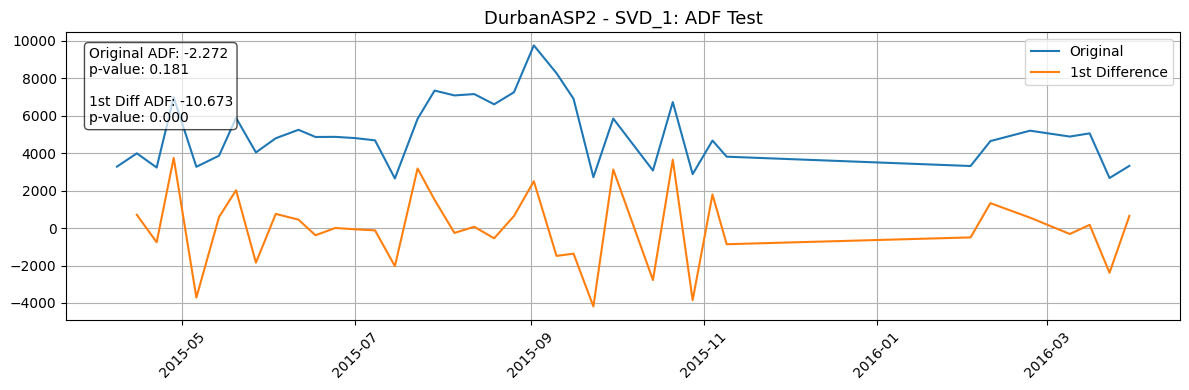

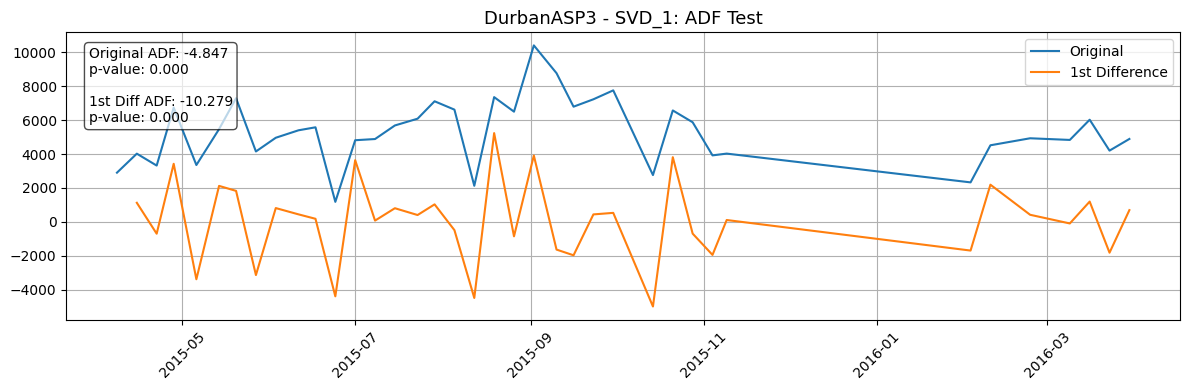

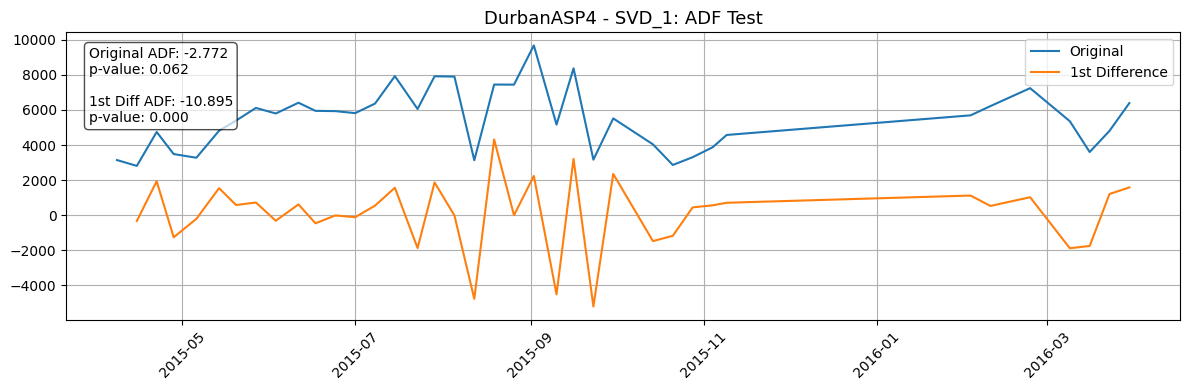

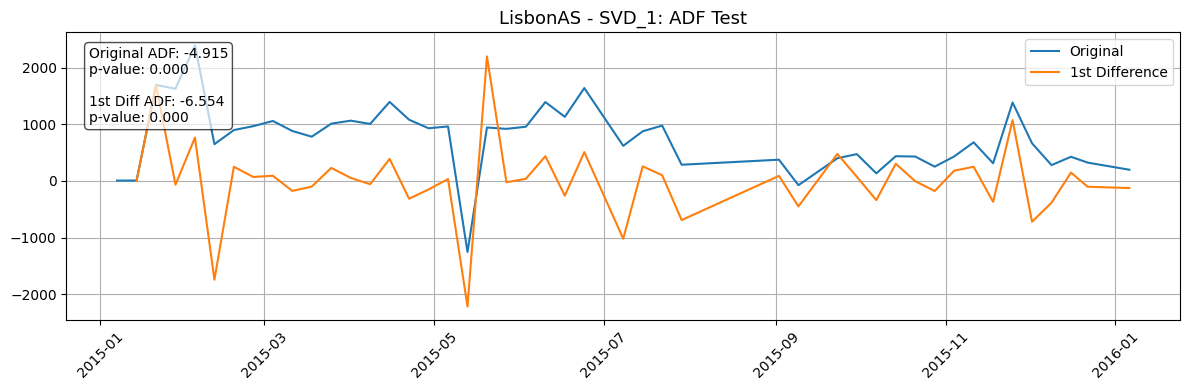

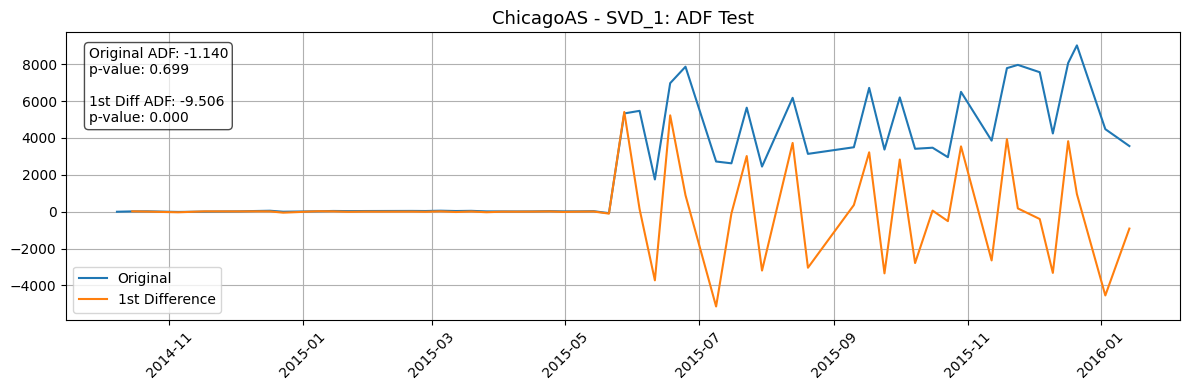

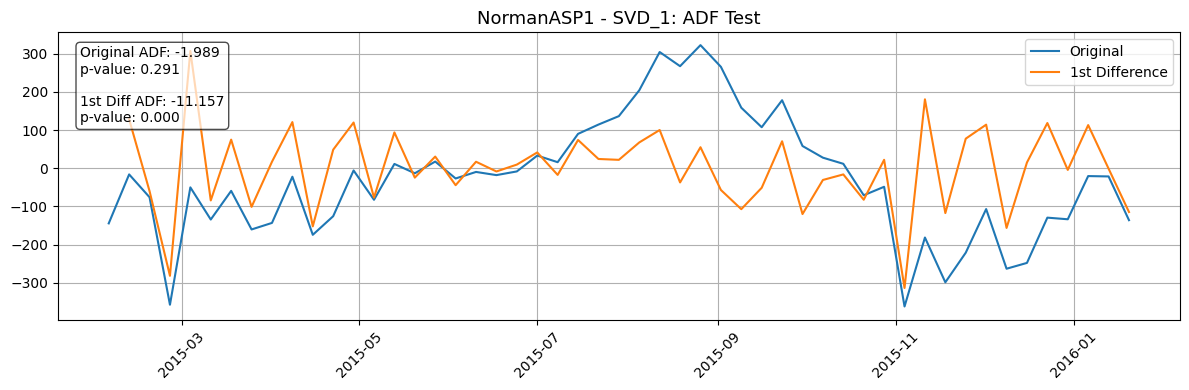

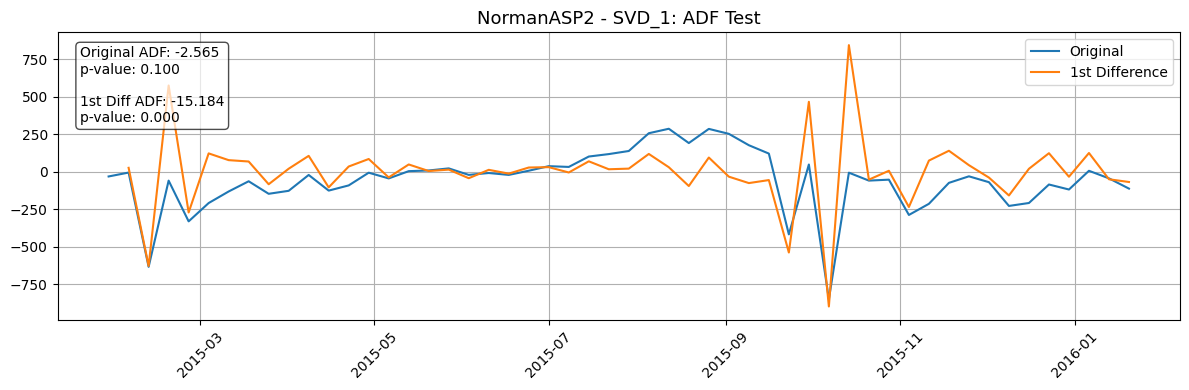

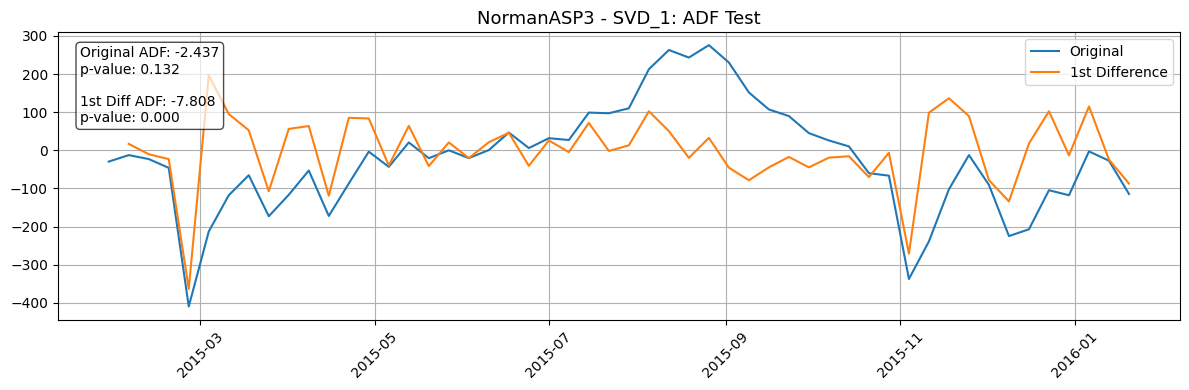

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 시각화를 위해 한글 깨짐 방지 (Mac/Windows 환경에 맞게 설정 가능)
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac 사용자
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자

# SVD_1이 존재하는지 확인
svd_col = "SVD_2"
positions = merged_df["Position"].unique()

for plant in positions:
    try:
        # 해당 plant의 데이터 정렬
        plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
        svd_series = plant_df[svd_col].dropna()

        # 인덱스를 날짜로 설정 (시계열적 의미 반영)
        svd_series.index = plant_df.loc[svd_series.index, "Date"]

        if len(svd_series) < 10:
            continue  # 너무 짧은 시계열은 skip

        # ADF Test on original
        result_orig = adfuller(svd_series)
        adf_orig_stat = result_orig[0]
        adf_orig_pval = result_orig[1]

        # 1차 차분
        diff_series = svd_series.diff().dropna()

        # ADF Test on differenced series
        result_diff = adfuller(diff_series)
        adf_diff_stat = result_diff[0]
        adf_diff_pval = result_diff[1]

        # 시각화
        plt.figure(figsize=(12, 4))
        plt.plot(svd_series, label='Original')
        plt.plot(diff_series, label='1st Difference')

        plt.legend()
        plt.title(f"{plant} - SVD_1: ADF Test", fontsize=13)
        plt.grid(True)
        plt.xticks(rotation=45)

        # 텍스트 박스에 결과 삽입
        textstr = f"""Original ADF: {adf_orig_stat:.3f}
p-value: {adf_orig_pval:.3f}

1st Diff ADF: {adf_diff_stat:.3f}
p-value: {adf_diff_pval:.3f}"""

        plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in {plant}: {e}")


In [41]:
merged_df

,Position,Country,City,Plant,Date,Volume of aeration tanks (m3),Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,...,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25
UK01A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-01-28,3600.0,17254.0,6.67,3.33,0.56,...,359.310911,-89.069847,35.938781,-80.955725,74.555696,204.643887,-44.432424,-75.566567,-28.152542,-139.776911
UK02A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-04,3600.0,7007.0,5.56,3.33,0.56,...,590.358520,-68.025554,-130.805420,-132.906720,124.226026,291.279505,-43.424642,-21.048832,-121.881068,-222.789861
UK03A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-11,3600.0,7197.0,5.56,4.44,2.78,...,573.401686,-61.099369,-127.653732,-125.362428,118.647594,264.290790,-21.878628,-38.734378,-73.757111,-183.435814
UK04A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-18,3600.0,6126.0,11.67,10.00,8.89,...,598.514885,-104.100813,-251.199593,-164.765123,188.262919,316.618341,-25.531131,10.909645,-205.971329,-358.286225
UK05A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-25,3600.0,6898.0,10.56,7.78,5.56,...,649.802823,-171.539529,-265.680254,-160.743738,161.550729,365.633693,-83.970978,-1.510278,-207.412524,-486.803164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,NormanASP3,United States,Norman,USNO2,2015-12-23,9751.2,31922.0,20.56,9.44,-1.67,...,79.002384,-127.434802,376.146945,19.078335,-74.248669,103.338832,-214.610152,-190.040699,242.680544,205.719815
N49C,NormanASP3,United States,Norman,USNO2,2015-12-30,9751.2,45538.0,0.56,-2.22,-5.56,...,16.530354,-34.585756,301.029151,29.531855,43.658539,-140.688473,100.361306,230.568493,-241.501097,-234.927432
N50C,NormanASP3,United States,Norman,USNO2,2016-01-06,9751.2,39274.0,11.67,8.33,4.44,...,-78.089860,-222.846491,431.170700,38.761832,-266.749614,451.700897,-581.428367,-649.538278,782.778535,448.260753
N51C,NormanASP3,United States,Norman,USNO2,2016-01-13,9751.2,34284.0,14.44,5.56,-3.33,...,-178.605008,-386.187801,824.720211,23.364556,-232.236579,570.914432,-596.004992,-930.312088,916.910955,438.088537


In [42]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 데이터 불러오기
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# 모든 SVD 컬럼 추출
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# 결과 저장 리스트
results = []

# 공정 리스트
positions = merged_df["Position"].unique()

# 각 공정 및 SVD 컬럼에 대해 ADF 수행
for plant in positions:
    plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
    plant_df = plant_df.set_index("Date")
    
    for svd_col in svd_cols:
        if svd_col not in plant_df.columns:
            continue

        svd_series = plant_df[svd_col].dropna()
        
        if len(svd_series) < 10:
            continue
        
        try:
            # ADF 테스트 - 원본
            result_orig = adfuller(svd_series)
            adf_stat_orig, pval_orig = result_orig[0], result_orig[1]

            # ADF 테스트 - 1차 차분
            diff_series = svd_series.diff().dropna()
            result_diff = adfuller(diff_series)
            adf_stat_diff, pval_diff = result_diff[0], result_diff[1]

            # 결과 저장
            results.append({
                "Position": plant,
                "SVD_Feature": svd_col,
                "ADF_Original": adf_stat_orig,
                "p_Original": pval_orig,
                "ADF_Diff": adf_stat_diff,
                "p_Diff": pval_diff
            })
        except:
            continue

# DataFrame 변환
adf_all_df = pd.DataFrame(results)
adf_all_df

,Position,SVD_Feature,ADF_Original,p_Original,ADF_Diff,p_Diff
0,NewcastleAS,SVD_1,-0.590209,0.873179,-2.757783,6.456184e-02
1,NewcastleAS,SVD_2,-4.016040,0.001329,-8.213559,6.717373e-13
2,NewcastleAS,SVD_3,-4.325824,0.000401,-7.317004,1.221845e-10
3,NewcastleAS,SVD_4,-3.918710,0.001901,-4.492688,2.027092e-04
4,NewcastleAS,SVD_5,-4.334199,0.000387,-7.568227,2.887376e-11
...,...,...,...,...,...,...
445,NormanASP3,SVD_21,-2.247541,0.189445,-7.174975,2.742229e-10
446,NormanASP3,SVD_22,-2.241015,0.191698,-5.705438,7.507208e-07
447,NormanASP3,SVD_23,-2.303293,0.170908,-7.330343,1.132195e-10
448,NormanASP3,SVD_24,-2.321719,0.165059,-7.854361,5.493076e-12


In [40]:
adf_all_df

,Position,SVD_Feature,ADF_Original,p_Original,ADF_Diff,p_Diff,ADF_LogDiff,p_LogDiff
0,NewcastleAS,SVD_1,-0.590209,0.873179,-2.757783,6.456184e-02,-2.931509,4.180467e-02
1,NewcastleAS,SVD_2,-4.016040,0.001329,-8.213559,6.717373e-13,-8.840226,1.676253e-14
2,NewcastleAS,SVD_3,-4.325824,0.000401,-7.317004,1.221845e-10,-4.588408,1.356757e-04
3,NewcastleAS,SVD_4,-3.918710,0.001901,-4.492688,2.027092e-04,-4.689027,8.823891e-05
4,NewcastleAS,SVD_5,-4.334199,0.000387,-7.568227,2.887376e-11,-7.666670,1.634262e-11
...,...,...,...,...,...,...,...,...
445,NormanASP3,SVD_21,-2.247541,0.189445,-7.174975,2.742229e-10,-6.179627,6.502690e-08
446,NormanASP3,SVD_22,-2.241015,0.191698,-5.705438,7.507208e-07,-1.552502,5.073980e-01
447,NormanASP3,SVD_23,-2.303293,0.170908,-7.330343,1.132195e-10,-3.848199,2.450938e-03
448,NormanASP3,SVD_24,-2.321719,0.165059,-7.854361,5.493076e-12,-11.104616,3.790096e-20


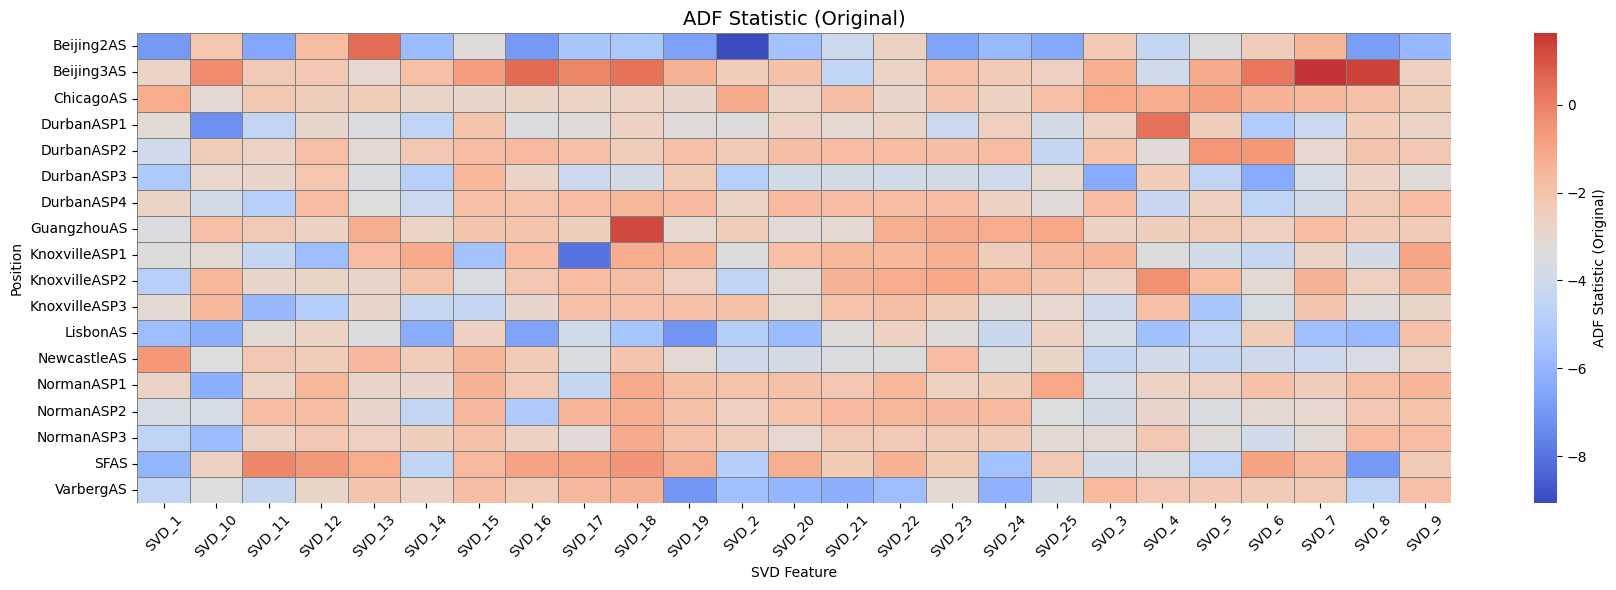

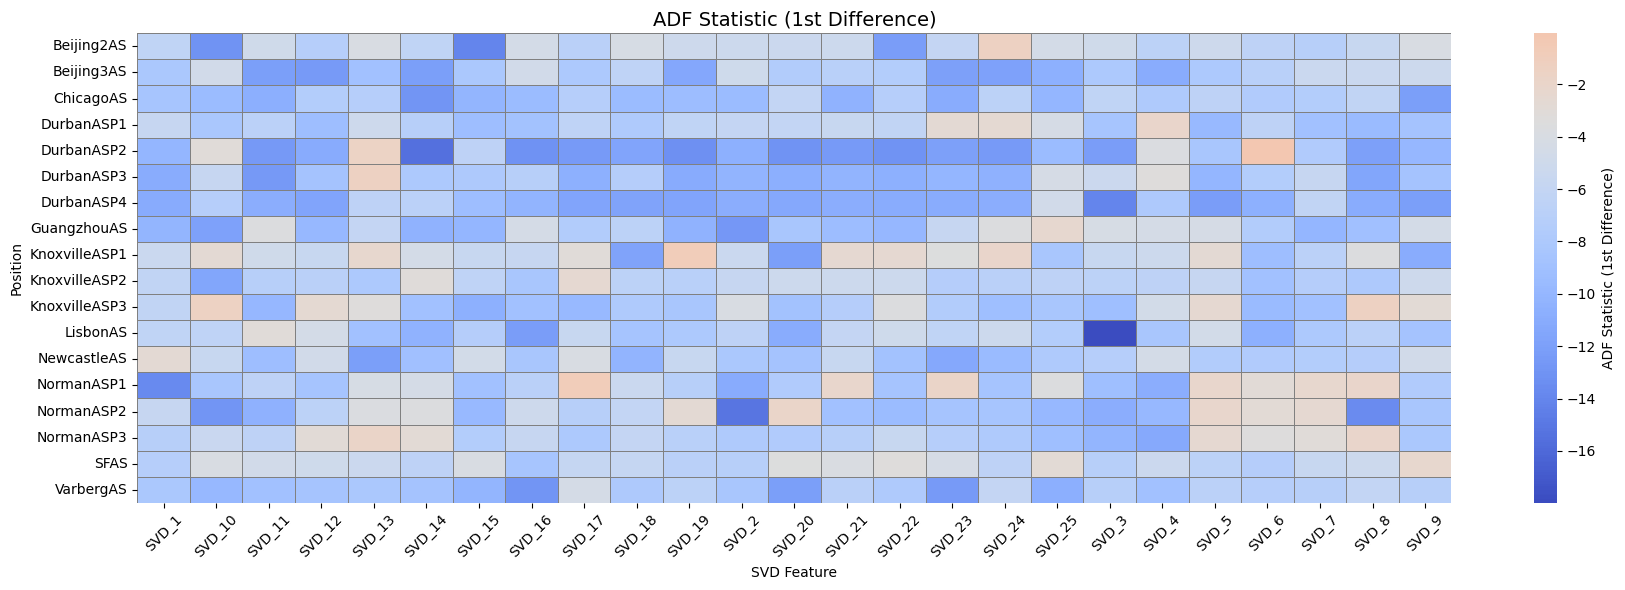

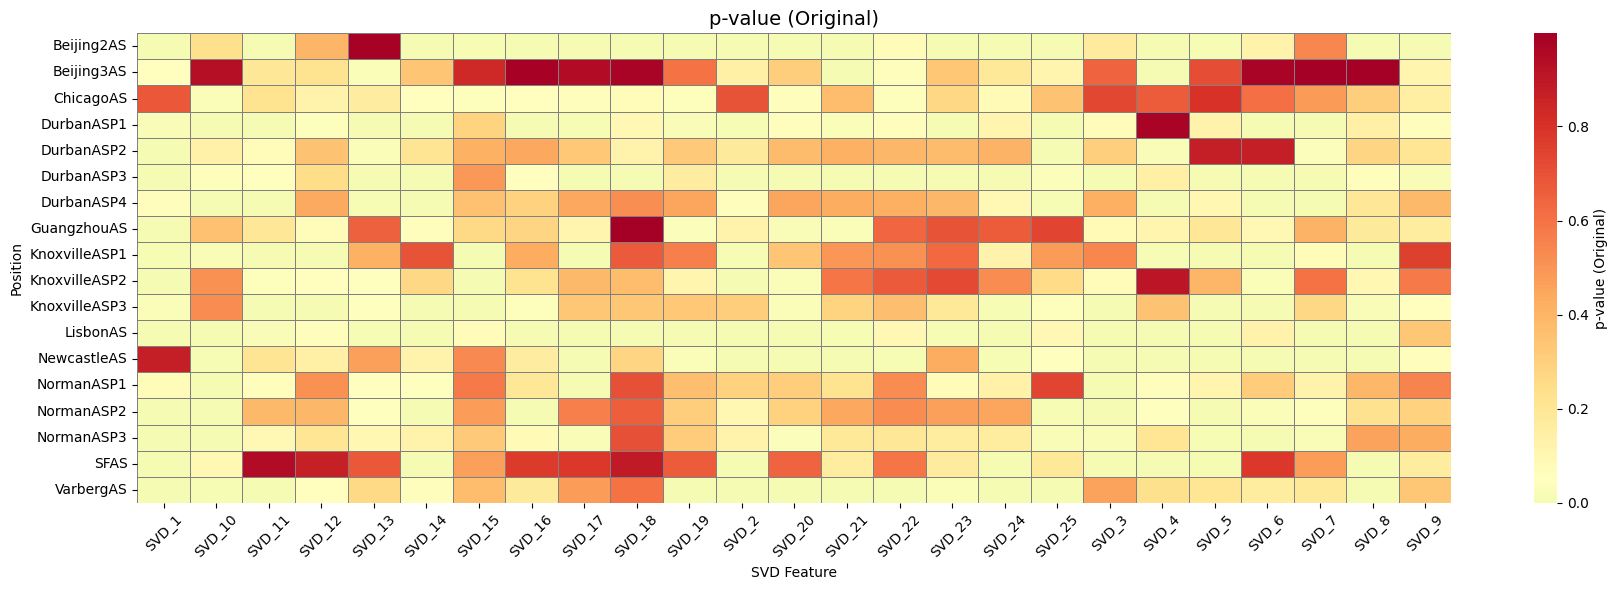

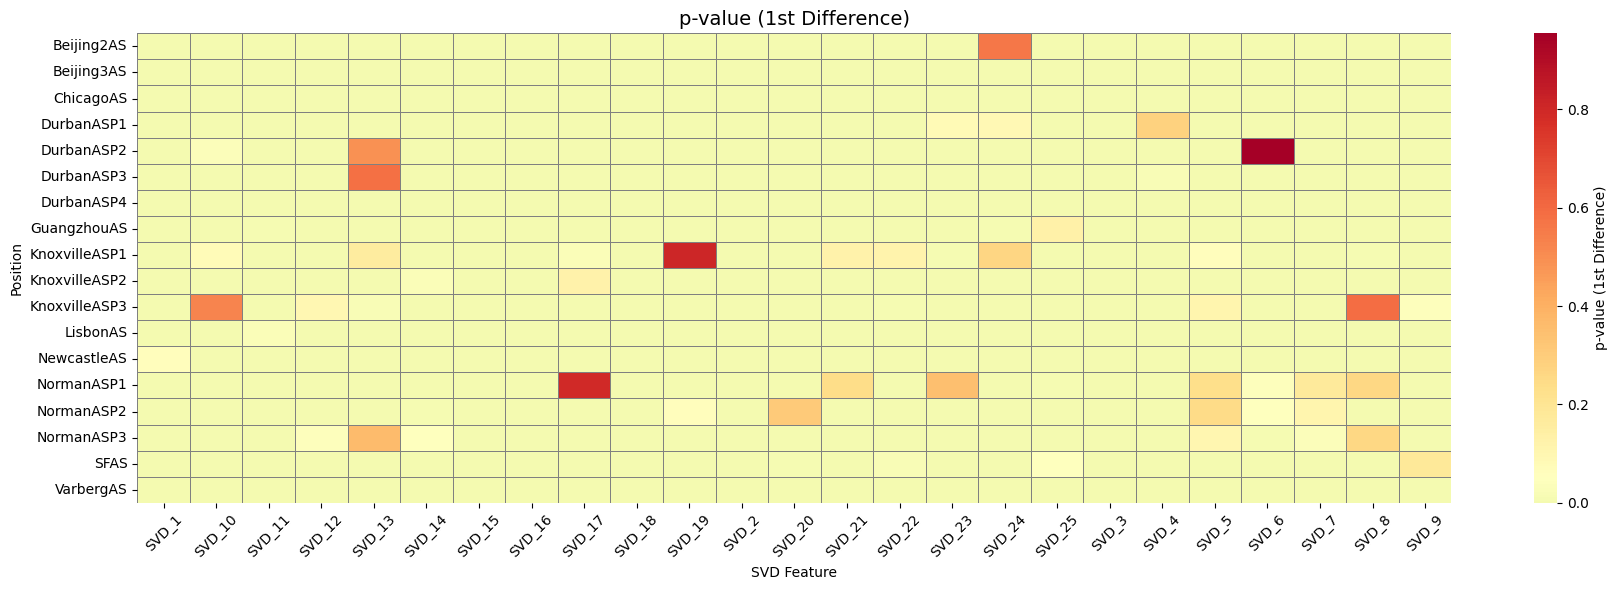

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


# ✅ 피벗 테이블로 변환 (시각화용)
pivot_adf_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Original")
pivot_adf_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Diff")

pivot_p_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Original")
pivot_p_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Diff")

# 🔷 Heatmap 시각화 함수 정의
def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    plt.figure(figsize=(18, 6))
    sns.heatmap(data, annot=False, fmt=".2f", cmap=cmap, center=center,
                cbar_kws={"label": title}, linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14)
    plt.xlabel("SVD Feature")
    plt.ylabel("Position")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🔷 시각화 실행
plot_heatmap(pivot_adf_orig, "ADF Statistic (Original)", center=-3.44)
plot_heatmap(pivot_adf_diff, "ADF Statistic (1st Difference)", center=-3.44)

plot_heatmap(pivot_p_orig, "p-value (Original)", center=0.05, cmap="RdYlGn_r")
plot_heatmap(pivot_p_diff, "p-value (1st Difference)", center=0.05, cmap="RdYlGn_r")


In [30]:
log_series = np.log(svd_series + 1)  # 0 방지
adfuller(log_series.dropna())


/Users/k23070952/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-4.136595124657467,
 0.0008420786744868315,
 0,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 66.07052340452529)

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# 1. 날짜 형식 정리
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# 2. 대상 컬럼 지정
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]
positions = merged_df["Position"].unique()

# 3. 결과 저장 리스트
results = []

# 4. 각 공정별 ADF 테스트 수행
for plant in positions:
    plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
    plant_df = plant_df.set_index("Date")
    
    for svd_col in svd_cols:
        if svd_col not in plant_df.columns:
            continue
        
        svd_series = plant_df[svd_col].dropna()
        if len(svd_series) < 10:
            continue

        try:
            # 🔹 ADF - 원본
            result_orig = adfuller(svd_series)
            adf_stat_orig, pval_orig = result_orig[0], result_orig[1]

            # 🔹 ADF - 1차 차분
            diff_series = svd_series.diff().dropna()
            result_diff = adfuller(diff_series)
            adf_stat_diff, pval_diff = result_diff[0], result_diff[1]

            # 🔹 ADF - 로그변환 + 1차 차분 (음수 보호를 위해 shift)
            min_val = svd_series.min()
            if min_val <= 0:
                shift_val = abs(min_val) + 1e-6
                shifted_series = svd_series + shift_val
            else:
                shifted_series = svd_series

            try:
                log_series = np.log(shifted_series)
                log_diff_series = log_series.diff().dropna()
                result_logdiff = adfuller(log_diff_series)
                log_diff_stat, log_diff_pval = result_logdiff[0], result_logdiff[1]
            except:
                log_diff_stat, log_diff_pval = np.nan, np.nan

            # 🔹 결과 저장
            results.append({
                "Position": plant,
                "SVD_Feature": svd_col,
                "ADF_Original": adf_stat_orig,
                "p_Original": pval_orig,
                "ADF_Diff": adf_stat_diff,
                "p_Diff": pval_diff,
                "ADF_LogDiff": log_diff_stat,
                "p_LogDiff": log_diff_pval
            })

        except Exception as e:
            continue

# 5. DataFrame으로 저장
adf_all_df = pd.DataFrame(results)




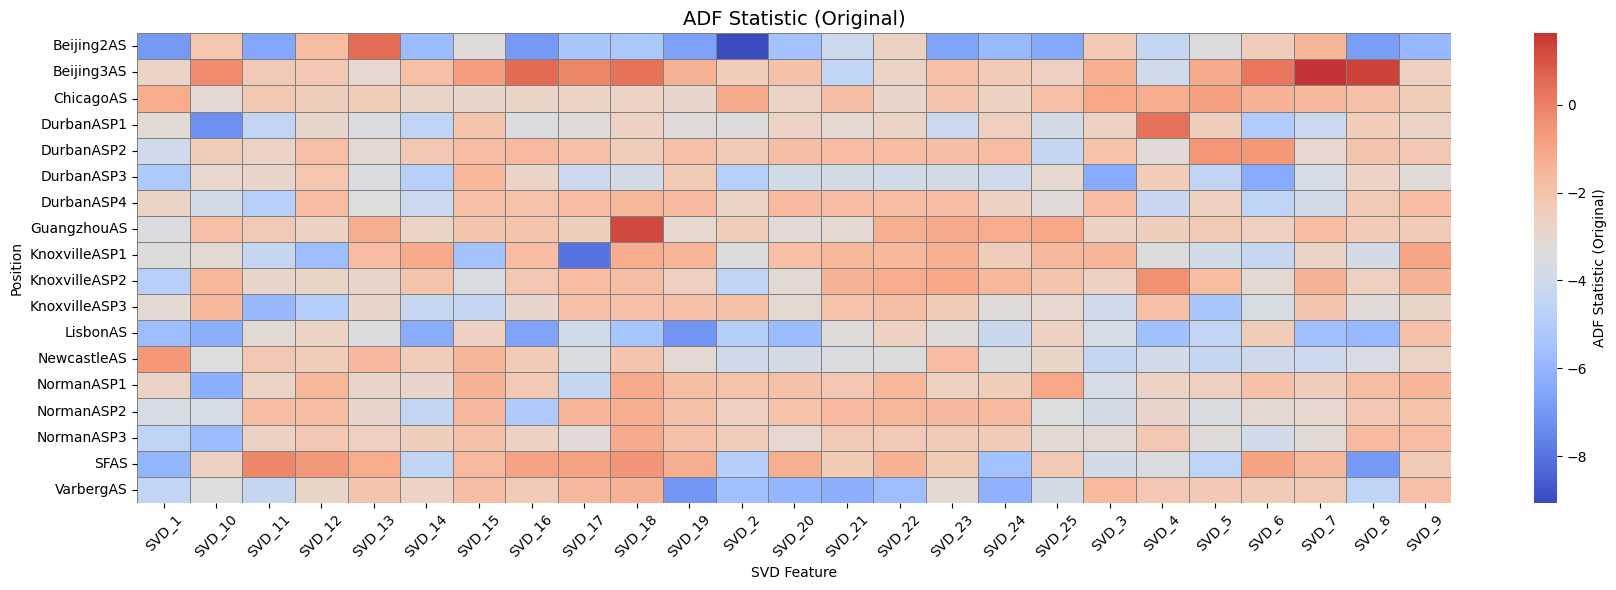

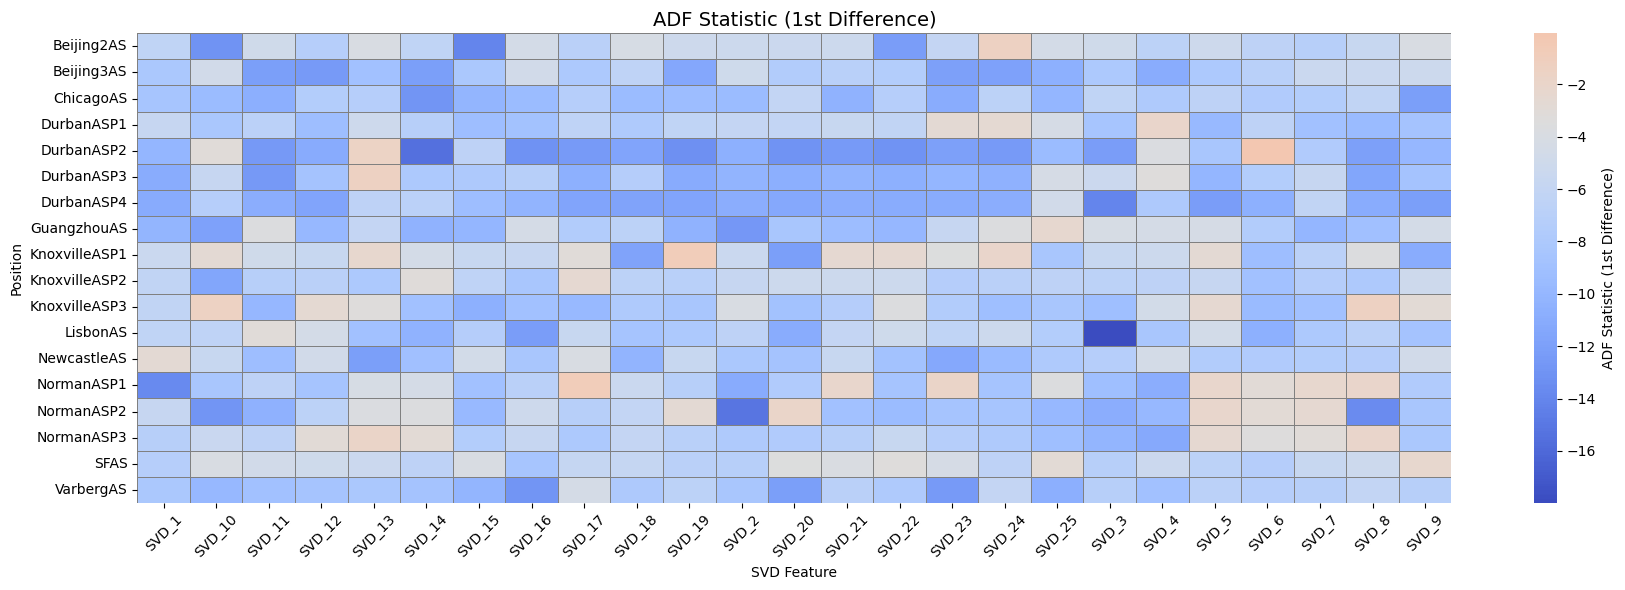

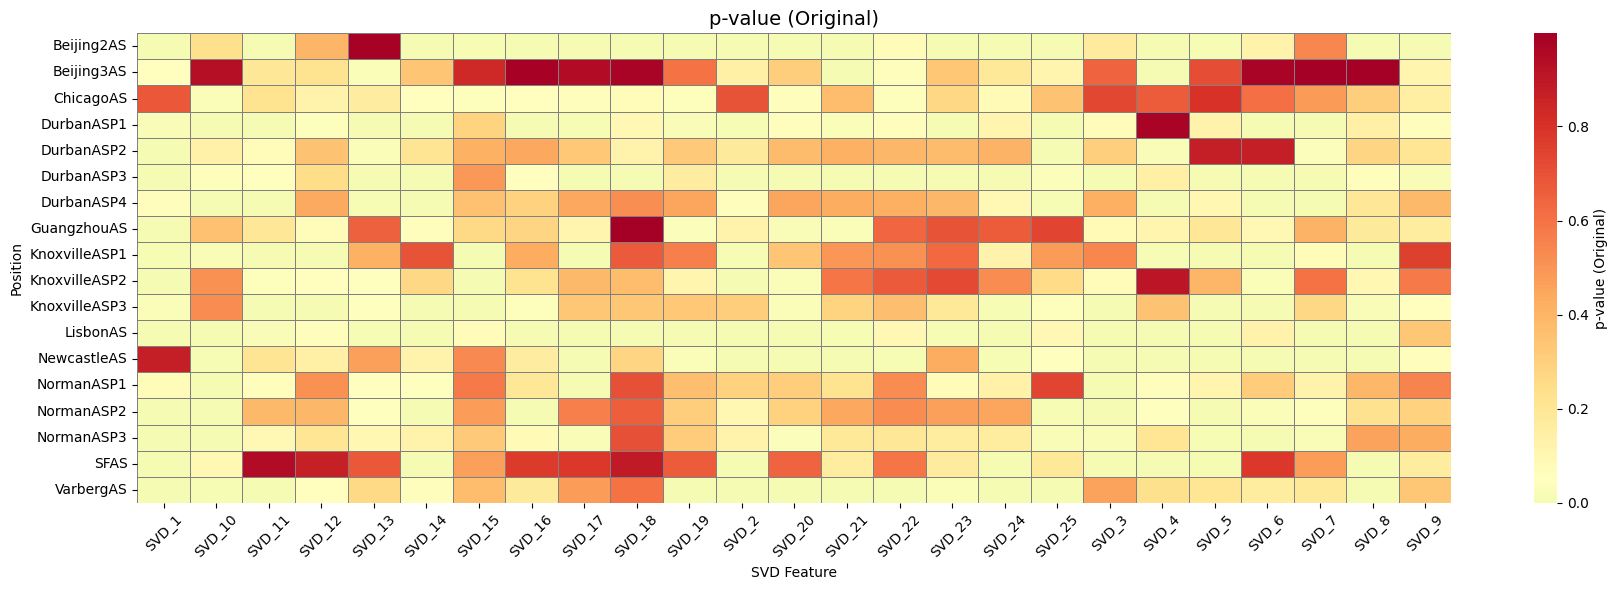

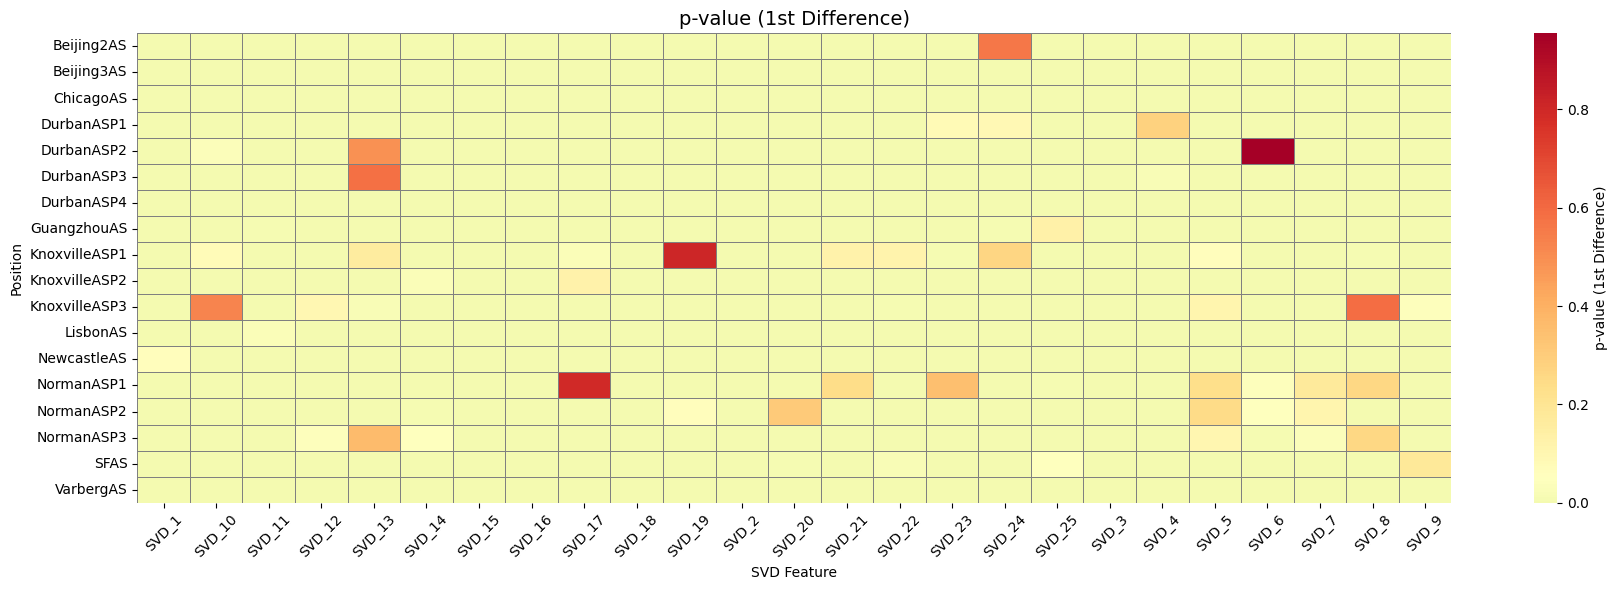

In [36]:
# ✅ 피벗 테이블로 변환 (시각화용)
pivot_adf_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Original")
pivot_adf_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Diff")

pivot_p_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Original")
pivot_p_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Diff")

# 🔷 Heatmap 시각화 함수 정의
def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    plt.figure(figsize=(18, 6))
    sns.heatmap(data, annot=False, fmt=".2f", cmap=cmap, center=center,
                cbar_kws={"label": title}, linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14)
    plt.xlabel("SVD Feature")
    plt.ylabel("Position")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🔷 시각화 실행
plot_heatmap(pivot_adf_orig, "ADF Statistic (Original)", center=-3.44)
plot_heatmap(pivot_adf_diff, "ADF Statistic (1st Difference)", center=-3.44)

plot_heatmap(pivot_p_orig, "p-value (Original)", center=0.05, cmap="RdYlGn_r")
plot_heatmap(pivot_p_diff, "p-value (1st Difference)", center=0.05, cmap="RdYlGn_r")